In [1]:
import os
import math
import glob
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt 
import ktplotspy as kpy
import scipy.stats as stats

import matplotlib as mpl
from matplotlib import cm
import seaborn as sns
import textwrap

from cellphonedb.src.core.methods import cpdb_analysis_method
from cellphonedb.src.core.methods import cpdb_statistical_analysis_method

In [2]:
# adata = sc.read_h5ad("/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/SG1_KUL_combined/AuthorAdata/iCMS3.basicPreprocessing.annotated.h5ad")

In [19]:
df_iCMS_marker = pd.read_csv('/node200data/18parkky/datasets/reference/marker_genes/colon/iCMS_marker/iCMS_marker_genes.csv')

iCMS2_up = list(df_iCMS_marker['iCMS2_Up'].dropna())
iCMS2_dw = list(df_iCMS_marker['iCMS2_Down'].dropna())
iCMS3_up = list(df_iCMS_marker['iCMS3_Up'].dropna())
iCMS3_dw = list(df_iCMS_marker['iCMS3_Down'].dropna())

In [ ]:
"/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/SG1_KUL_combined/AuthorAdata/NanoMnT.AlleleTable.tsv"

## Load and Lay NanoMnT results

In [20]:
list_uniqueID = [ f"{tup.Index.split('_')[-1].split('-')[0]}_{list(tup)[5]}" for tup in adata.obs.itertuples() ]
adata.obs['unique_ID'] = list_uniqueID

dup_uid = list() 
for uid, edf in adata.obs.groupby("unique_ID"):
    if len(edf) != 1: dup_uid.append( uid )
    
adata = adata[~(adata.obs['unique_ID'].isin(dup_uid))].copy()

sc.tl.score_genes(adata, iCMS2_up, score_name='iCMS2_up')
sc.tl.score_genes(adata, iCMS2_dw, score_name='iCMS2_dw')
sc.tl.score_genes(adata, iCMS3_up, score_name='iCMS3_up')
sc.tl.score_genes(adata, iCMS3_dw, score_name='iCMS3_dw')

In [5]:
PATH_SG1_metadata = "/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/CRC-SG1/EGAD00001008555-metadata/organized_metadata.tsv"
PATH_KUL_metadata = "/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/KUL/organized_metadata.tsv"

df_SG1_metadata = pd.read_csv(PATH_SG1_metadata, sep='\t')
df_KUL_metadata = pd.read_csv(PATH_KUL_metadata, sep='\t')

df_metadata = pd.concat( [df_SG1_metadata, df_KUL_metadata] )

In [ ]:
df = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/CRC-SG1/synapse-metadata/patient_clinical_information.csv', encoding = "ISO-8859-1")
# set(df[df['patient.ID'].isin(['CRC2817', 'CRC2783', 'SC035', 'SC044'])]['patient.ID'])

In [ ]:
def merge_NanoMnT_results( PATH_cellranger_out, list_file_ID=None ):

    list_df_at = list()

    for DIR_cellranger_out in glob.glob(f"{PATH_cellranger_out}/*"):
        if os.path.isdir(DIR_cellranger_out)==False: continue
        file_ID = DIR_cellranger_out.split("/")[-1]
        if list_file_ID != None and file_ID not in list_file_ID: continue

        try:
            df_at = pd.read_csv(f"{DIR_cellranger_out}/outs/possorted_genome_bam.STR_allele_table.tsv", sep='\t')
        except:
            continue 
        
        df_at['file_ID'] = file_ID
        list_df_at.append( df_at )
        
    df_at = pd.concat(list_df_at)
    df_at = df_at[df_at['CB'].isna()==False]
    df_at['CB_wSample'] = [ f'{tup.CB.split("-")[0]}_{tup.file_ID}' for tup in df_at.itertuples() ]
    df_at["diff"] = df_at["read_STR_length"] - df_at["reference_STR_allele"] # diff<0 = Deletions++, diff>0 = Insertions++ 
    
    for file_ID in set(df_at['file_ID']):
        if file_ID not in list_file_ID:
            print(f"{file_ID} not found")
    
    return df_at

list_SG1_file_ids = list(df_metadata[df_metadata['patient.ID'].isin(['CRC2786', 'CRC2821', 'CRC2783', 'CRC2817'])]['file_ID'])
list_KUL_MSI_file_ids = list(df_metadata[df_metadata['patient.ID'].isin(['SC035', 'SC044'])]['file_ID'])
list_KUL_MSS_file_ids = list(df_metadata[df_metadata['patient.ID'].isin(['SC040', 'SC041'])]['file_ID'])

df_SG1_at = merge_NanoMnT_results( "/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/CRC-SG1/cellranger", list_SG1_file_ids )
df_KUL_MSI_at = merge_NanoMnT_results( "/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/KUL/MSI_H/cellranger", list_KUL_MSI_file_ids )
df_KUL_MSS_at = merge_NanoMnT_results( "/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/KUL/iCMS3_MSS", list_KUL_MSS_file_ids )

df_at = pd.concat([df_SG1_at, df_KUL_MSI_at, df_KUL_MSS_at])

dict_Sample_to_Patient = { list(tup)[3] : list(tup)[2] for tup in df_metadata.itertuples() }
df_at['patient'] = [ dict_Sample_to_Patient[Sample] for Sample in df_at['file_ID'] ]
df_at['unique_ID'] = [ f"{tup.CB.split('-')[0]}_{tup.patient}" for tup in df_at.itertuples() ]

### Filter out reads with invalid flanking sequences

In [8]:
list_filt_at = list()
for tup in df_at.itertuples():
    if ("*" in tup.left_flanking_seq[-3:]) or ("*" in tup.right_flanking_seq[:3]) or (tup.left_flanking_seq[-1].upper() == tup.repeat_unit) or (tup.right_flanking_seq[0].upper() == tup.repeat_unit):
        continue
    else:
        list_filt_at.append( tup )

In [9]:
df_filt_at = pd.DataFrame(list_filt_at)
df_filt_at.drop('Index', axis=1, inplace=True)

In [407]:
df_at.to_csv("/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/SG1_KUL_combined/AuthorAdata/NanoMnT.AlleleTable.tsv", sep='\t', index=False)
df_filt_at.to_csv("/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/SG1_KUL_combined/AuthorAdata/NanoMnT.AlleleTable.filtered.tsv", sep='\t', index=False)

In [21]:
df_filt_at = pd.read_csv("/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/SG1_KUL_combined/AuthorAdata/NanoMnT.AlleleTable.filtered.tsv", sep='\t')

### Label cell types

In [22]:
dict_uid_to_celltype = { tup.unique_ID : tup.cell_type_lvl1 for tup in adata.obs.itertuples() }
for uid, edf in df_filt_at.groupby("unique_ID"):
    try:
        dict_uid_to_celltype[uid]
    except KeyError:
        dict_uid_to_celltype[uid] = "N/A"
        
df_filt_at['celltype'] = [ dict_uid_to_celltype[uid] for uid in df_filt_at['unique_ID'] ]
df_filt_at = df_filt_at[(df_filt_at['celltype']!='N/A')]
df_filt_at['isTumor'] = [ ct=='Tumor' for ct in df_filt_at['celltype'] ]

### Collect STR loci with sufficient coverage in both tumor and non-tumor clusters

In [23]:
min_coverage = 10 # per patient; at least 20 coverage by tumor reads and 20 coverage by non-tumor reads
list_locusCoverageInfo = list()

for locus, edf in df_filt_at.groupby("locus"):
    if len(set(edf['unique_ID'])) < min_coverage: continue 
    
    for patient, edf2 in edf.groupby("patient"):
        for isTumor, edf3 in edf2.groupby("isTumor"):
            list_locusCoverageInfo.append( [locus, patient, isTumor, len(edf3), int(edf.iloc[0].reference_STR_allele), np.mean(edf3['diff']), np.std(edf3['diff']) ] )

df_locusCoverageInfo = pd.DataFrame(list_locusCoverageInfo, columns=['locus', 'patient', 'isTumor', 'coverage', 'reference_STR_allele', 'avgDiff', 'stdDiff'])

In [24]:
sufficientlyCoveredLoci = list()
for locus, edf in df_locusCoverageInfo.groupby("locus"):
    if min( edf['coverage'] ) >= min_coverage and len(edf)==16:
        sufficientlyCoveredLoci.append( edf )

sufficientlyCoveredLoci = pd.concat(sufficientlyCoveredLoci)
sufficientlyCoveredLoci.reset_index(inplace=True, drop=True)
len(set(sufficientlyCoveredLoci['locus']))

42

In [25]:
np.mean(sufficientlyCoveredLoci[(sufficientlyCoveredLoci['isTumor']==True)]['coverage'])

153.45833333333334

In [1160]:
# STR loci in 'sufficientlyCoveredLoci' are covered by at least 20 tumor and non-tumor reads accross *all* 4 patients   

<Axes: xlabel='reference_STR_allele', ylabel='patient'>

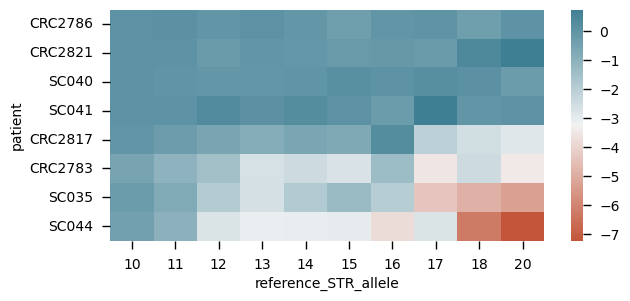

In [26]:
# Calculate tumor-normal by microsatellite length
sufficientlyCoveredLoci2 = list()
for reference_STR_allele, edf in sufficientlyCoveredLoci.groupby("reference_STR_allele"):
    for patient, edf2 in edf.groupby("patient"):
        mean_of_tumorAvgDiff    = np.mean(edf2[edf2['isTumor']==True]['avgDiff'])
        mean_of_normalAvgDiff   = np.mean(edf2[edf2['isTumor']==False]['avgDiff'])

        sufficientlyCoveredLoci2.append( [reference_STR_allele, patient, mean_of_tumorAvgDiff - mean_of_normalAvgDiff] )
sufficientlyCoveredLoci2 = pd.DataFrame(sufficientlyCoveredLoci2, columns=['reference_STR_allele', 'patient', 'tumor_minus_normal'])

plt.figure(figsize=(7, 3), dpi=100)
palette_e = sns.diverging_palette(20, 220, as_cmap=True)
# palette_e = 'vlag_r'
# # list_reference_STR_allele = sufficientlyCoveredLoci2.pop('reference_STR_allele')
list_heatmap_patient_order = ['CRC2817', 'CRC2783', 'SC035', 'SC044']
list_heatmap_patient_order = ['CRC2786', 'CRC2821', 'SC040', 'SC041', 'CRC2817', 'CRC2783', 'SC035', 'SC044']

sns.heatmap(sufficientlyCoveredLoci2.pivot( index='patient', columns='reference_STR_allele', values='tumor_minus_normal' ).reindex(list_heatmap_patient_order), 
            cmap=palette_e, 
            # vmax=0, 
            # annot=True, fmt=".2f"
            )

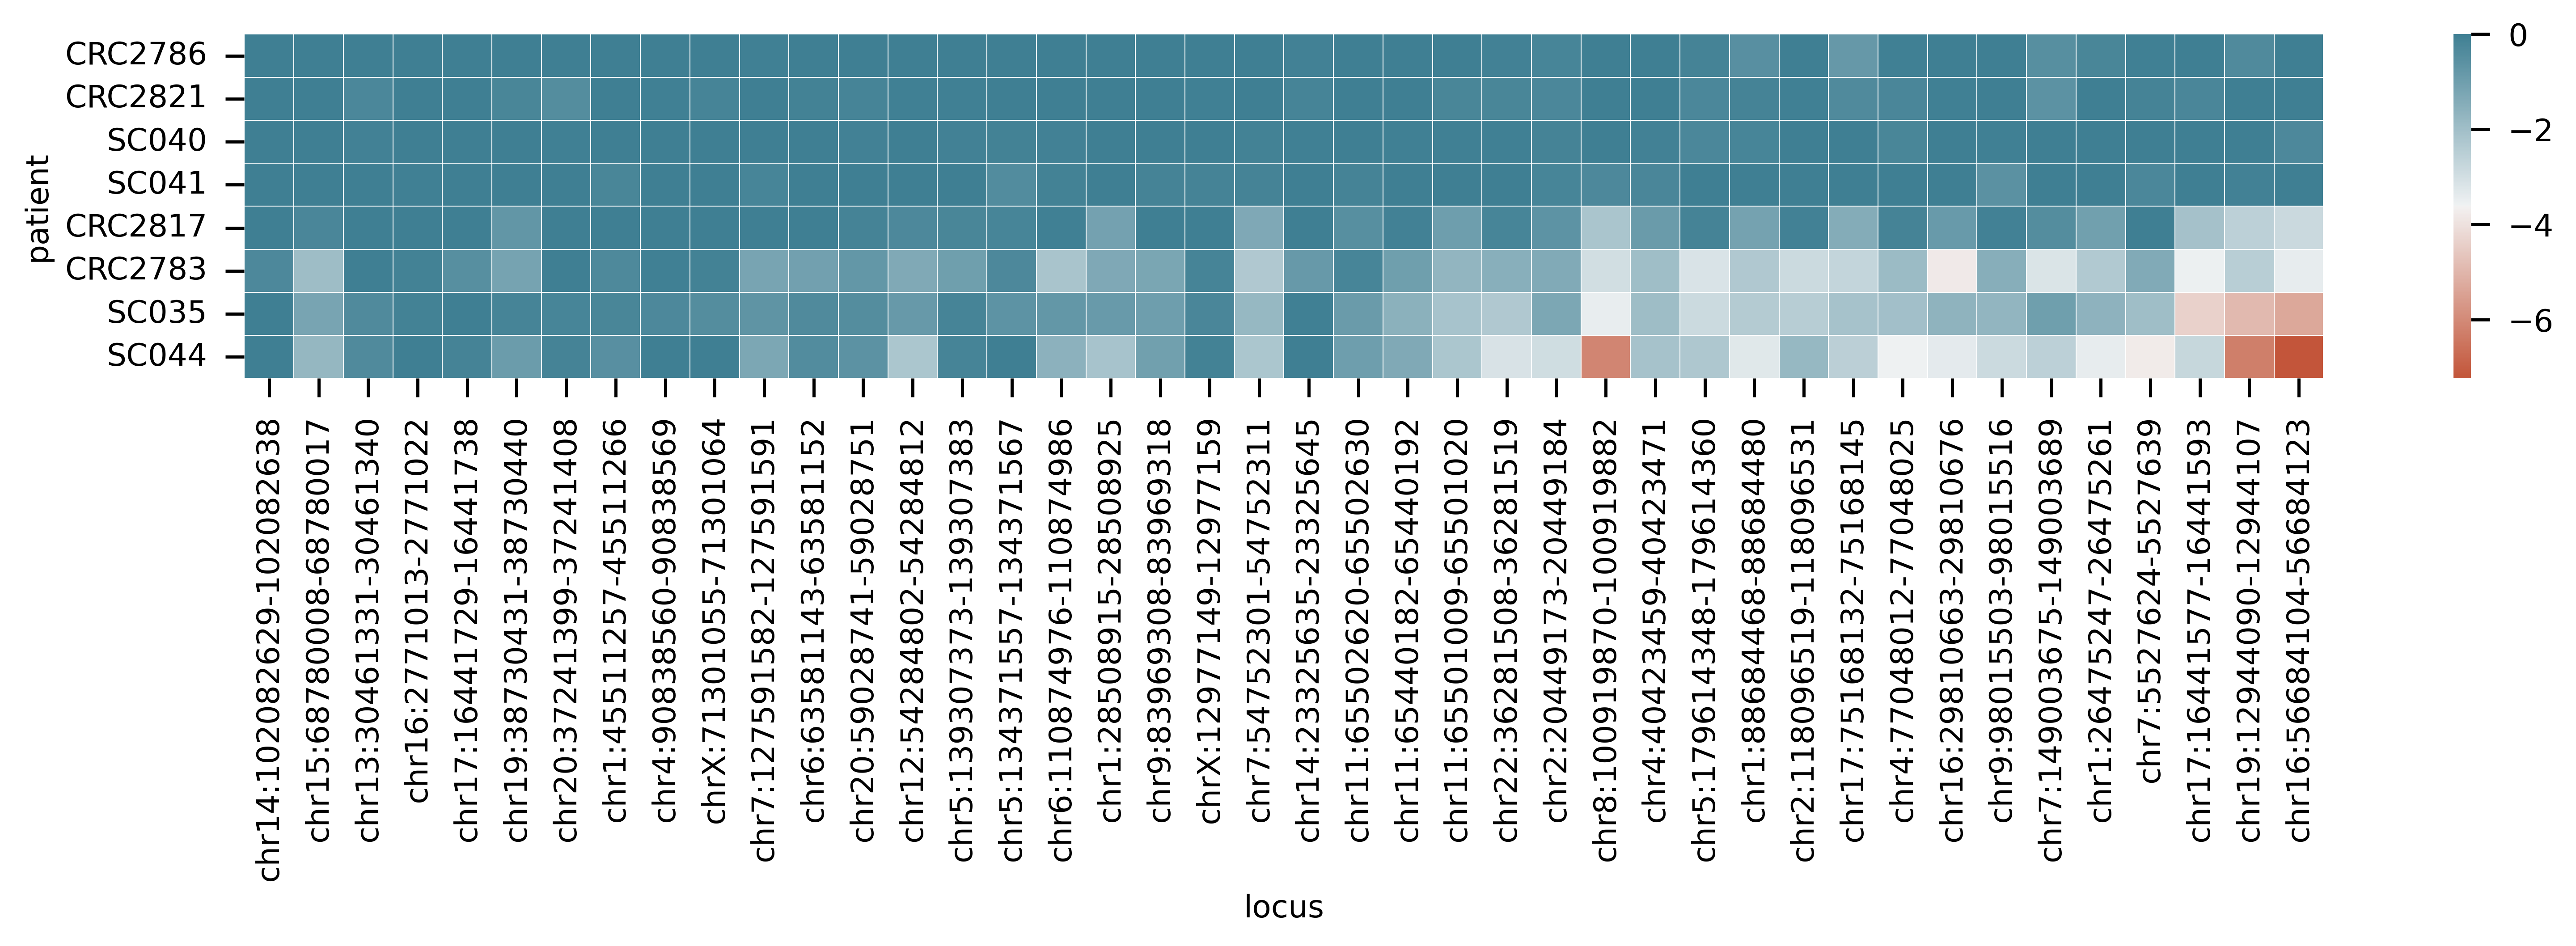

In [28]:
# Calculate tumor-normal by locus
sufficientlyCoveredLoci3 = list()
for locus, edf in sufficientlyCoveredLoci.groupby("locus"):
    for patient, edf2 in edf.groupby("patient"):
        mean_of_tumorAvgDiff    = np.mean(edf2[edf2['isTumor']==True]['avgDiff'])
        mean_of_normalAvgDiff   = np.mean(edf2[edf2['isTumor']==False]['avgDiff'])

        sufficientlyCoveredLoci3.append( [locus, edf.iloc[0].reference_STR_allele, patient, mean_of_tumorAvgDiff - mean_of_normalAvgDiff] )
        
sufficientlyCoveredLoci3 = pd.DataFrame(sufficientlyCoveredLoci3, columns=['locus', 'reference_STR_allele', 'patient', 'tumor_minus_normal'])
sufficientlyCoveredLoci3 = sufficientlyCoveredLoci3.pivot( index='locus', columns='patient', values='tumor_minus_normal' )[list_heatmap_patient_order]
sufficientlyCoveredLoci3['reference_STR_allele'] = [ int(locus.split(":")[1].split("-")[1])-int(locus.split(":")[1].split("-")[0])+1 for locus in sufficientlyCoveredLoci3.index ]
sufficientlyCoveredLoci3.sort_values("reference_STR_allele", inplace=True)

list_reference_STR_allele = sufficientlyCoveredLoci3['reference_STR_allele']
lut = dict(zip(list_reference_STR_allele.unique(), sns.color_palette('Paired', 12)))
row_colors = list_reference_STR_allele.map(lut)

plt.figure(figsize=(15, 2), dpi=500)
palette_e = sns.diverging_palette(20, 220, as_cmap=True)

f = sns.heatmap(sufficientlyCoveredLoci3[list_heatmap_patient_order].T, 
            cmap=palette_e, vmax=0, linewidth=.05,
            # row_colors=row_colors, 
            # annot=True, fmt=".2f"
            )

# f.set_xticklabels([]);

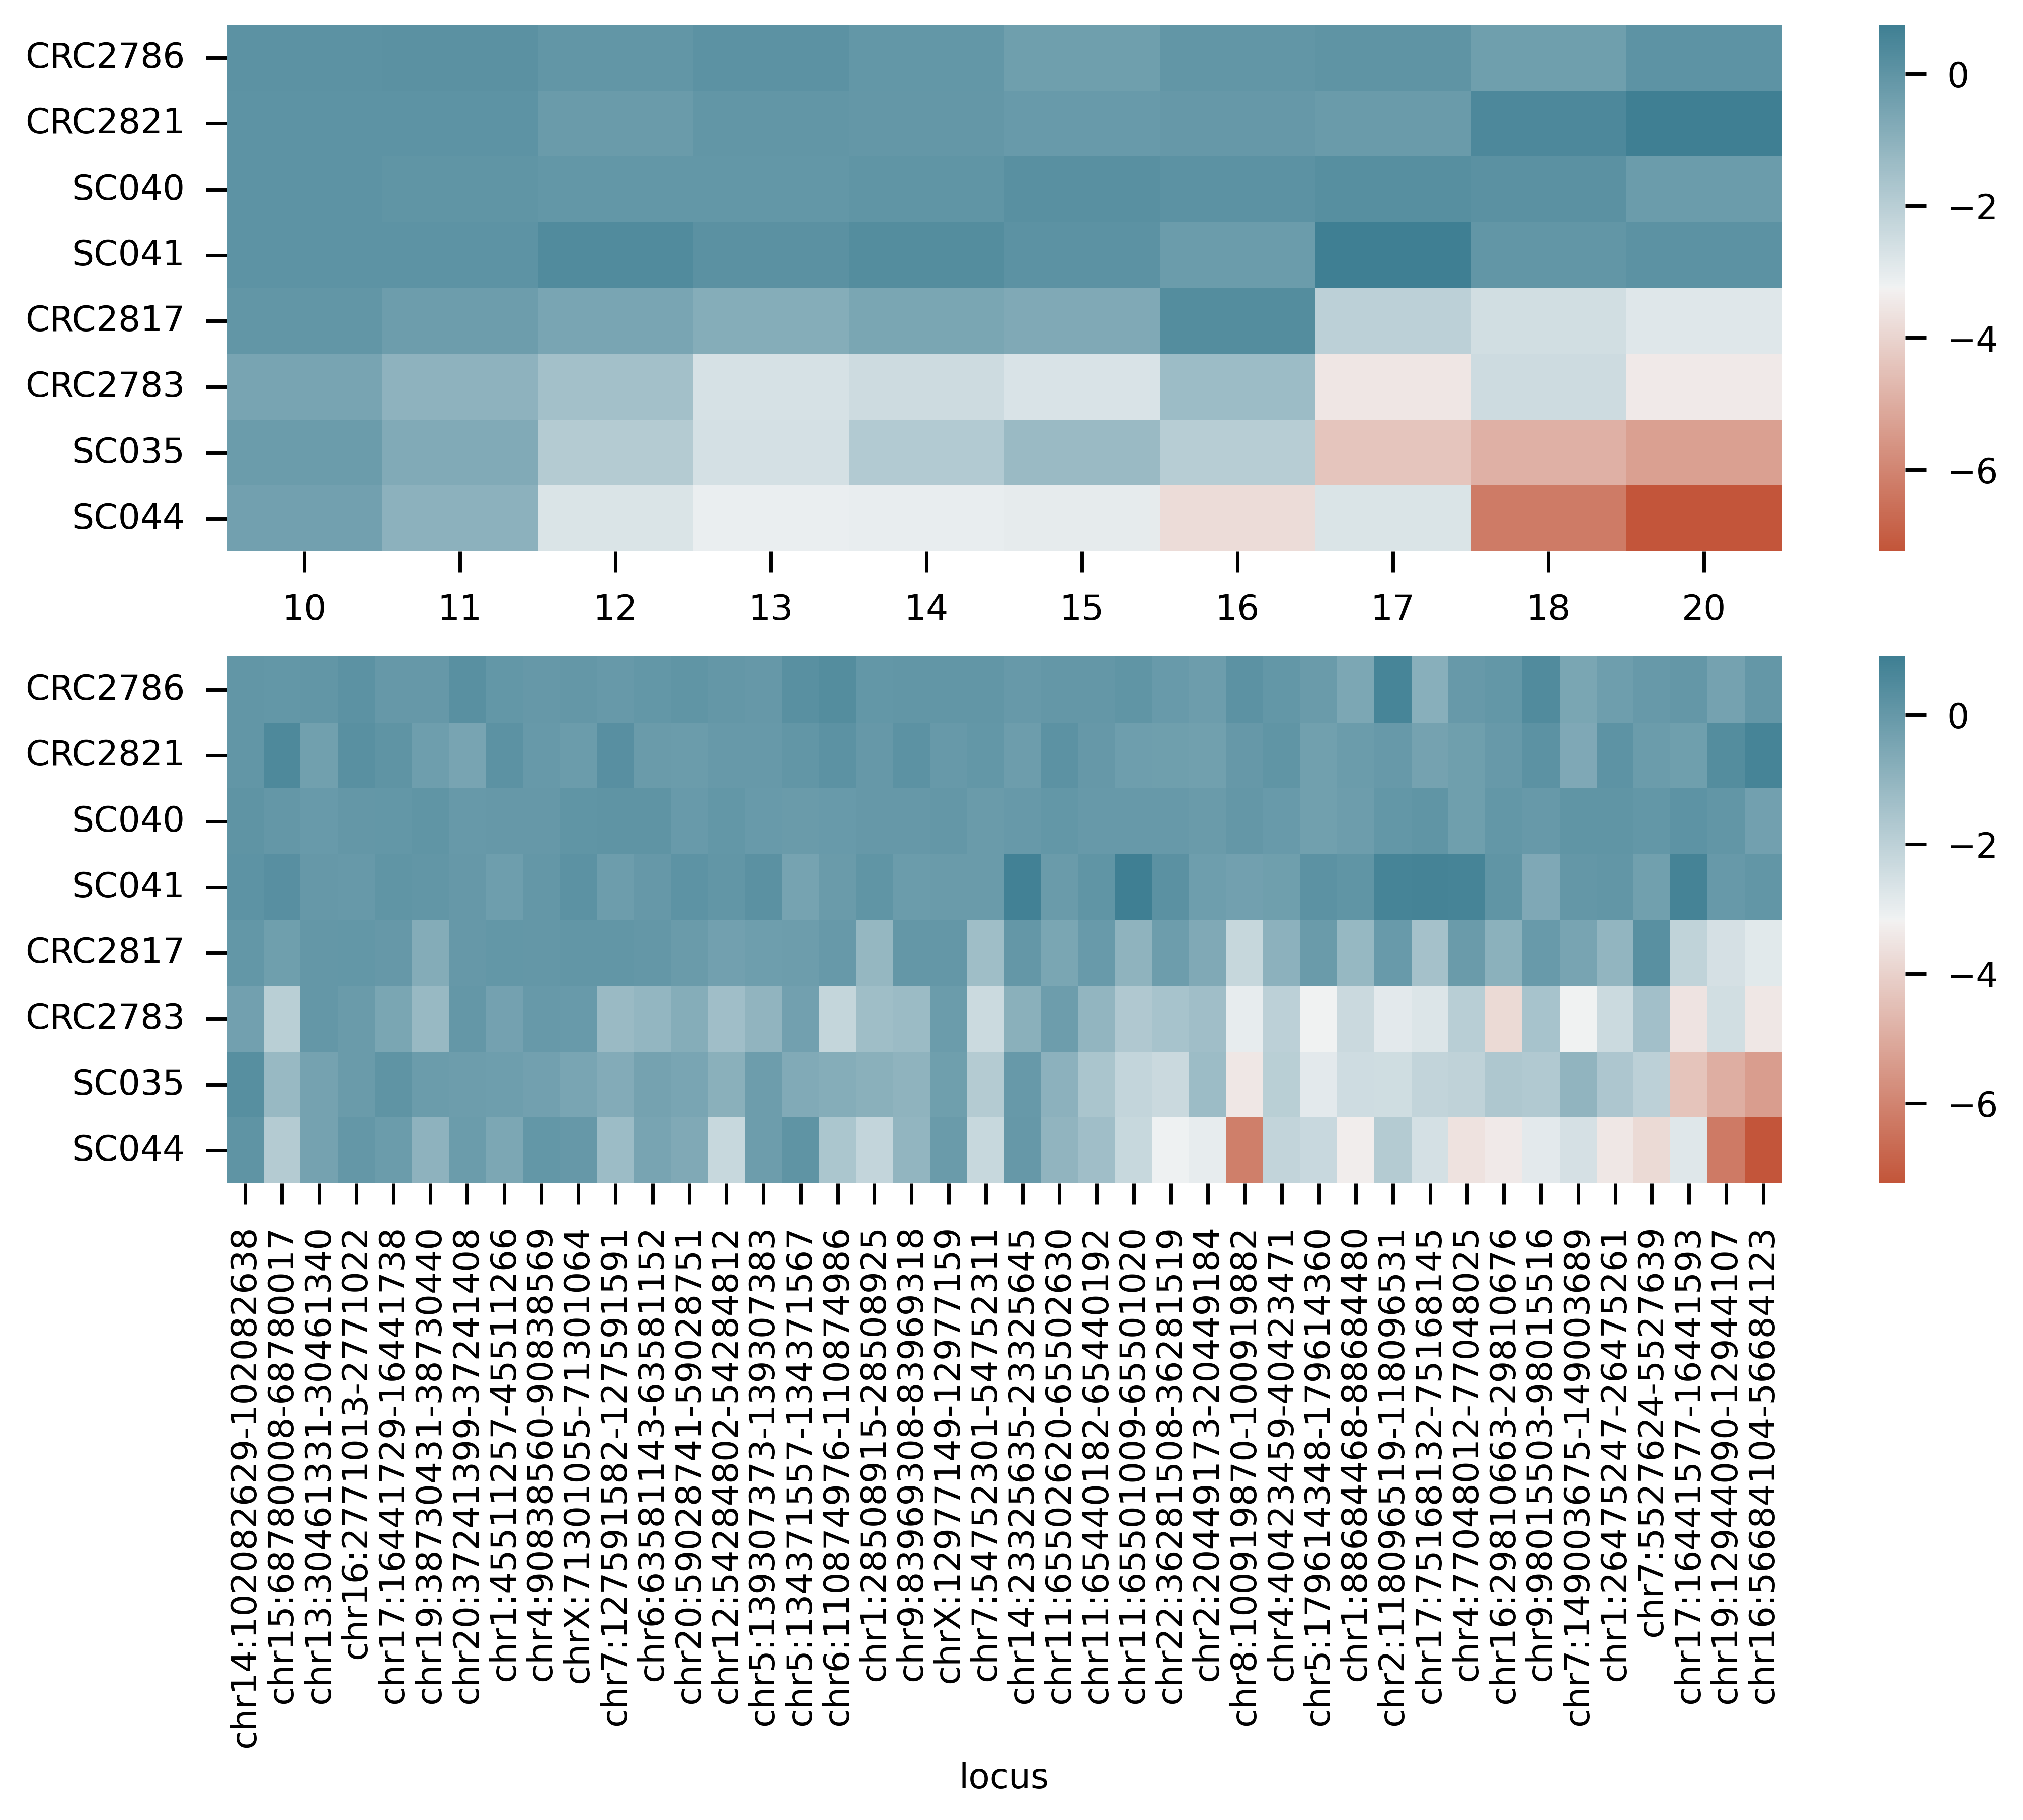

In [29]:
fig, axes = plt.subplots(2, 1, sharey=True, figsize=(10, 6), dpi=500 ) 

f = sns.heatmap(sufficientlyCoveredLoci2.pivot( index='patient', columns='reference_STR_allele', values='tumor_minus_normal' ).reindex(list_heatmap_patient_order), 
            cmap=palette_e, 
            # vmax=0, 
            # annot=True, fmt=".2f",
            ax=axes[0]
            )
f.set_xlabel("");
f.set_ylabel("");

f = sns.heatmap(sufficientlyCoveredLoci3[list_heatmap_patient_order].T, 
            cmap=palette_e, 
            # vmax=0, 
            # linewidth=.05,
            # row_colors=row_colors, 
            # annot=True, fmt=".2f"
            ax=axes[1],
            )
f.set_ylabel("");

<Axes: xlabel='patient', ylabel='dummy'>

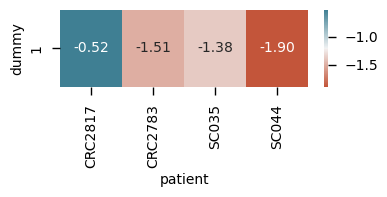

In [30]:
sufficientlyCoveredLoci4 = pd.DataFrame([ ['CRC2817', 1, np.mean(sufficientlyCoveredLoci3['CRC2817']), ], 
                                         ['CRC2783', 1, np.mean(sufficientlyCoveredLoci3['CRC2783']), ],
                                         ['SC035', 1, np.mean(sufficientlyCoveredLoci3['SC035']), ],
                                         ['SC044', 1, np.mean(sufficientlyCoveredLoci3['SC044']), ],], columns=['patient', 'dummy', 'avgDiff'])

plt.figure(figsize=(4, 1), dpi=100)
sns.heatmap(sufficientlyCoveredLoci4.pivot( index='dummy', columns='patient', values='avgDiff' )[['CRC2817', 'CRC2783', 'SC035', 'SC044']], 
            cmap=palette_e, annot=True, fmt=".2f")

### Label results

In [31]:
dict_uid_to_RawSTRprofile   = { uid : [np.mean(edf['diff']), np.std(edf['diff']), len(edf) ] for uid, edf in df_filt_at.groupby("unique_ID") }
dict_uid_to_FiltSTRprofile  = { uid : [np.mean(edf['diff']), np.std(edf['diff']), len(edf) ] for uid, edf in df_filt_at[(df_filt_at['locus'].isin( sufficientlyCoveredLoci3.index ))].groupby("unique_ID") }

In [32]:
list_RawAvgDiff, list_RawStdDiff, list_RawSTRn      = list(), list(), list()
list_FiltAvgDiff, list_FiltStdDiff, list_FiltSTRn   = list(), list(), list()

for tup in adata.obs.itertuples():
    try:
        STRprofile = dict_uid_to_RawSTRprofile[tup.unique_ID]
        list_RawAvgDiff.append( STRprofile[0] )
        list_RawStdDiff.append( STRprofile[1] )
        list_RawSTRn.append( STRprofile[2] )
    except KeyError:
        list_RawAvgDiff.append( -1 )
        list_RawStdDiff.append( -1 )
        list_RawSTRn.append( -1 )
        
    try:
        STRprofile = dict_uid_to_FiltSTRprofile[tup.unique_ID]
        list_FiltAvgDiff.append( STRprofile[0] )
        list_FiltStdDiff.append( STRprofile[1] )
        list_FiltSTRn.append( STRprofile[2] )
    except KeyError:
        list_FiltAvgDiff.append( -1 )
        list_FiltStdDiff.append( -1 )
        list_FiltSTRn.append( -1 )
        
adata.obs['RawAvgDiff'] = list_RawAvgDiff
adata.obs['RawStdDiff'] = list_RawStdDiff
adata.obs['RawSTRn'] = list_RawSTRn

adata.obs['FiltAvgDiff'] = list_FiltAvgDiff
adata.obs['FiltStdDiff'] = list_FiltStdDiff
adata.obs['FiltSTRn'] = list_FiltSTRn

In [18]:
adata = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/SG1_KUL_combined/AuthorAdata/iCMS3.basicPreprocessing.annotated.NanoMnT_labeled.h5ad')

In [37]:
set(adata.obs['cell_type_lvl1'])

{'B',
 'CD4+ T',
 'CD8+ T',
 'DC',
 'Endothelial',
 'Entericglial',
 'Fibroblast',
 'Mast',
 'McDC',
 'NK',
 'Naive T',
 'Neutrophils',
 'Normal epithelial',
 'Plasma',
 'SMC/Pericyte',
 'Tumor',
 'pDC'}

In [ ]:
dict_ctlvl1_to_majorCompartment = {
 'B' : 'Immune',
 'CD4+ T' : 'Immune',
 'CD8+ T' : 'Immune',   
 'DC' : 'Immune',   
 
}

In [48]:
adata_obs_oi = adata.obs.sample(20000, random_state=42).sort_values("FiltAvgDiff").copy()
adata_obs_oi = adata_obs_oi[adata_obs_oi['RawSTRn']>=30]
adata_obs_oi.sort_values('RawAvgDiff', inplace=True)
adata_obs_oi.reset_index(inplace=True)
adata_obs_oi.reset_index(inplace=True)
adata_obs_oi.head(5)

level_0                           index  nCount_RNA.x  nFeature_RNA.x  \
0        0  KUL5_EXT125_CAGTAACAGCAATCTC-1          5690            2727   
1        1  KUL5_EXT125_AATCGGTAGTTGCAGG-1         18513            5172   
2        2  KUL5_EXT125_GAGTCCGTCCTATTCA-1         25555            6249   
3        3  KUL5_EXT125_CCACGGAAGCCACCTG-1         22158            5540   
4        4  KUL5_EXT125_GCAAACTCACTGTTAG-1         10555            4205   

   percent.mt sample.ID patient.ID sample.origin dataset   cell.type  ...  \
0   10.954540    EXT125      SC044       Tumor-2    KUL5  Epithelial  ...   
1    7.089456    EXT125      SC044       Tumor-2    KUL5  Epithelial  ...   
2   12.105746    EXT125      SC044       Tumor-2    KUL5  Epithelial  ...   
3    7.244044    EXT125      SC044       Tumor-2    KUL5  Epithelial  ...   
4   24.359621    EXT125      SC044       Tumor-2    KUL5  Epithelial  ...   

   iCMS2_dw  iCMS3_up  iCMS3_dw  RawAvgDiff  RawStdDiff  RawSTRn  FiltAvgDiff  \
0  0.049769  0.063155 -0.046335   -3.905660    4.822370       53    -2.428571   
1  0.064821  0.029533 -0.049089   -3.851852    3.783039       54    -2.000000   
2  0.109700  0.033799 -0.030381   -3.790541    4.087313      148    -1.222222   
3  0.094817  0.058248 -0.024594   -3.784000    4.243742      125    -1.466667   
4  0.108519  0.090685 -0.005965   -3.591398    3.348042       93    -2.416667   

   FiltStdDiff  FiltSTRn  isTumor  
0     2.128523         7     True  
1     1.673320         5     True  
2     2.148787         9     True  
3     1.857118        15     True  
4     1.605113        12     True  

[5 rows x 50 columns]

<Axes: xlabel='RawAvgDiff', ylabel='cell_type_lvl1'>

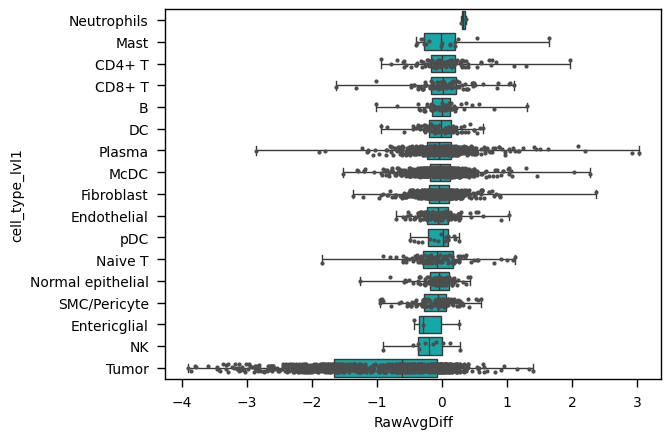

In [54]:
ct_lvl = 'cell_type_lvl1'
# plt.figure(figsize=(12, 3))
ranks = adata_obs_oi.groupby(ct_lvl)["RawAvgDiff"].mean().fillna(0).sort_values()[::-1].index
sns.boxplot(data=adata_obs_oi, x='RawAvgDiff', y=ct_lvl, whis=np.inf, color="c",  order = ranks)
sns.stripplot(data=adata_obs_oi, x='RawAvgDiff', y=ct_lvl, 
              jitter=0.2, size=3, color=".3", linewidth=0, order = ranks)

## MSI hetereogeneity analysis

In [ ]:
normal_ct = ['B', 'Fibroblast', 'Enteriglial', 'Endothelial'
 'Mast',
 'McDC',
 'Neutrophils',
 'PlasmaB',
 'T_NK',
 'pDC']

### Rough STR size distribution

In [34]:
adata.obs['isTumor'] = [ str(ct_lvl1 == 'Tumor') for ct_lvl1 in adata.obs['cell_type_lvl1'] ]

In [70]:
sns.color_palette("Paired")

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

CRC2786	-0.09
CRC2821	-0.06
SC040	0.03
SC041	0.05
CRC2817	-0.59
CRC2783	-1.72
SC035	-1.76
SC044	-2.81


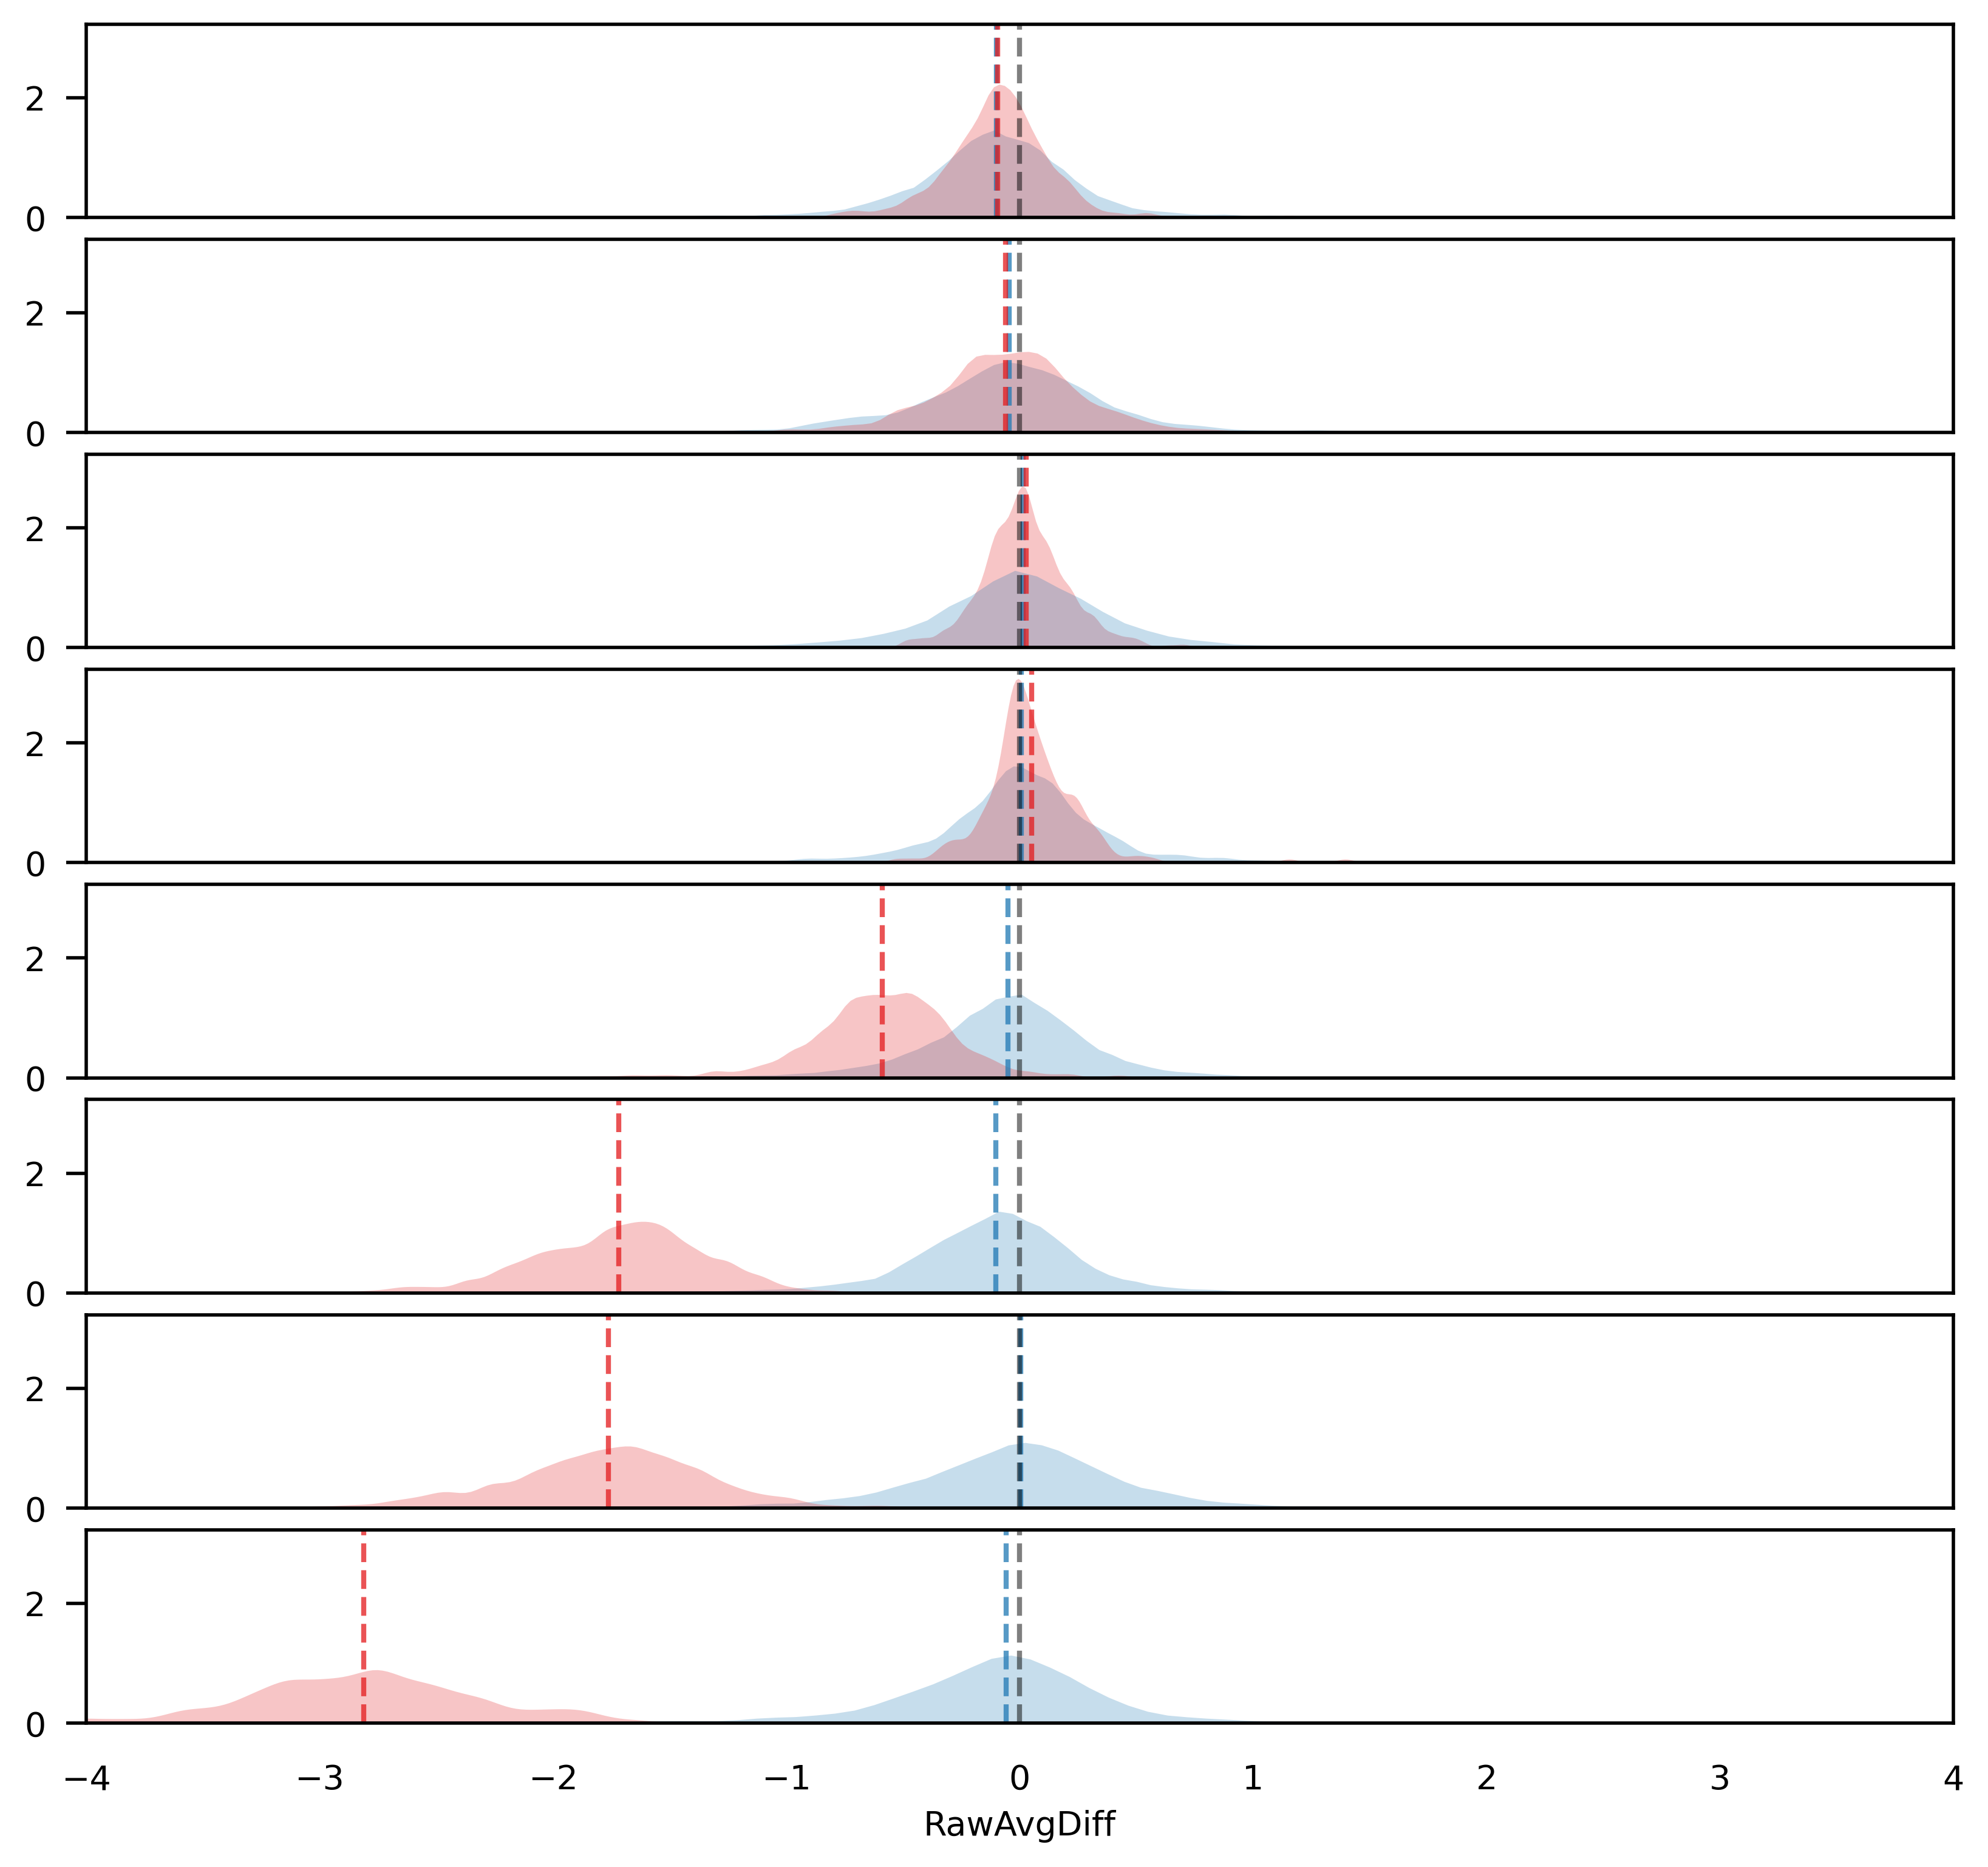

In [35]:
# All patients 
fig, axes = plt.subplots(8, 1, figsize=( 8, 7.5 ), dpi=400, sharex=True, sharey=True)
plot_type_oi = sns.kdeplot
palette_e = { 'True' : sns.color_palette("Paired")[5], 'False' : sns.color_palette("Paired")[1] }

min_STRn = 10
bw_adjust_e = 0.5

for idx, patient in enumerate(['CRC2786', 'CRC2821', 'SC040', 'SC041', 'CRC2817', 'CRC2783', 'SC035', 'SC044']):

    adata_obs_oi = adata[(adata.obs['RawSTRn']>=min_STRn) & 
                        (adata.obs['patient.ID']==patient)].obs
    # tumor_normal_diff = np.mean( adata_obs_oi[(adata_obs_oi['isTumor']=="False")]['UnprocAvgDiff'] ) - np.mean( adata_obs_oi[(adata_obs_oi['isTumor']=="True")]['UnprocAvgDiff'] )
    # print(len(adata_obs_oi))
    print(f'{patient}\t{round(np.mean( adata_obs_oi[(adata_obs_oi['isTumor']=="True")]['RawAvgDiff'] ), 2)}')
    # print(round(tumor_normal_diff, 2))
    # print(np.std( adata_obs_oi[(adata_obs_oi['isTumor']=="True")]['AvgDiff'] ))
    # print(np.mean( adata_obs_oi[(adata_obs_oi['isTumor']=="True")]['AvgDiff'] ))

    plot_type_oi(data=adata_obs_oi, 
                        x='RawAvgDiff', hue='isTumor', 
                        legend=None, 
                        fill=True, linewidth=0, common_norm=False, bw_adjust=bw_adjust_e,
                        palette=palette_e, ax=axes[idx], 
                        )
    for isTumor, edf in adata_obs_oi.groupby("isTumor"):
        axes[idx].axvline( np.mean(edf['RawAvgDiff']), color=palette_e[isTumor], ls='--', alpha=0.75, )
    axes[idx].set_ylabel('');
    # axes[0].set_yticklabels([]);
    axes[idx].tick_params(left=True, bottom=False);
    
    axes[idx].axvline( 0, color='black', ls='--', alpha=0.5, )

axes[idx].set_xlim([-4, 4]);
# axes[idx].set_ylim([0, 2.2]);

fig.tight_layout(pad=0.05,);

<Axes: xlabel='RawAvgDiff', ylabel='patient.ID'>

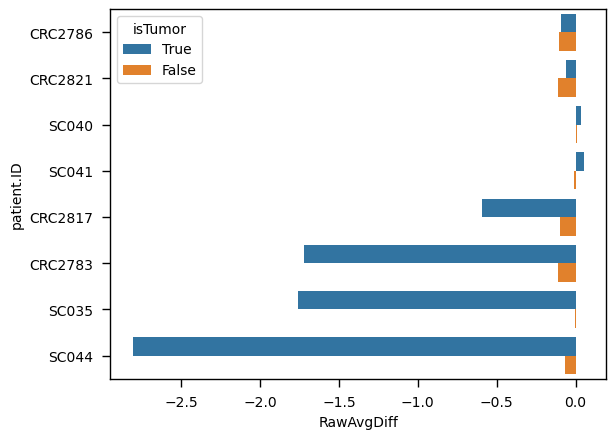

In [36]:
# All patients - boxenplot
plot_type_oi = sns.boxenplot
palette_e = { 'True' : sns.color_palette("Paired")[5], 'False' : 'gray' }

min_STRn = 10
bw_adjust_e = 0.5

sns.barplot( adata.obs, 
            y='patient.ID', x='RawAvgDiff', hue='isTumor', 
            errorbar=None, 
            order=['CRC2786', 'CRC2821', 'SC040', 'SC041', 'CRC2817', 'CRC2783', 'SC035', 'SC044'],
            )

In [37]:
for patient in ['CRC2786', 'CRC2821', 'SC040', 'SC041', 'CRC2817', 'CRC2783', 'SC035', 'SC044']:
    ranksum_stat, ranksum_pval = stats.ranksums( list(adata.obs[(adata.obs['patient.ID']==patient) & (adata.obs['isTumor']=='True')]['RawAvgDiff']), 
                                                list(adata.obs[(adata.obs['patient.ID']==patient) & (adata.obs['isTumor']=='False')]['RawAvgDiff']) )
    print(f'{patient}\t{ranksum_stat}\t{ranksum_pval}')

CRC2786	-0.09050996289416834	0.9278819772051159
CRC2821	1.7702126572004047	0.07669172160084554
SC040	1.1990336835045308	0.2305148484348981
SC041	1.6524137831190169	0.09845022766560728
CRC2817	-37.85761509772663	0.0
CRC2783	-45.4193183617122	0.0
SC035	-51.32587135180254	0.0
SC044	-32.25451506489273	3.0408037328163654e-228


CRC2786	0.05
CRC2821	0.02
SC040	0.16
SC041	0.35
CRC2817	-0.57
CRC2783	-1.14
SC035	-1.38
SC044	-1.95


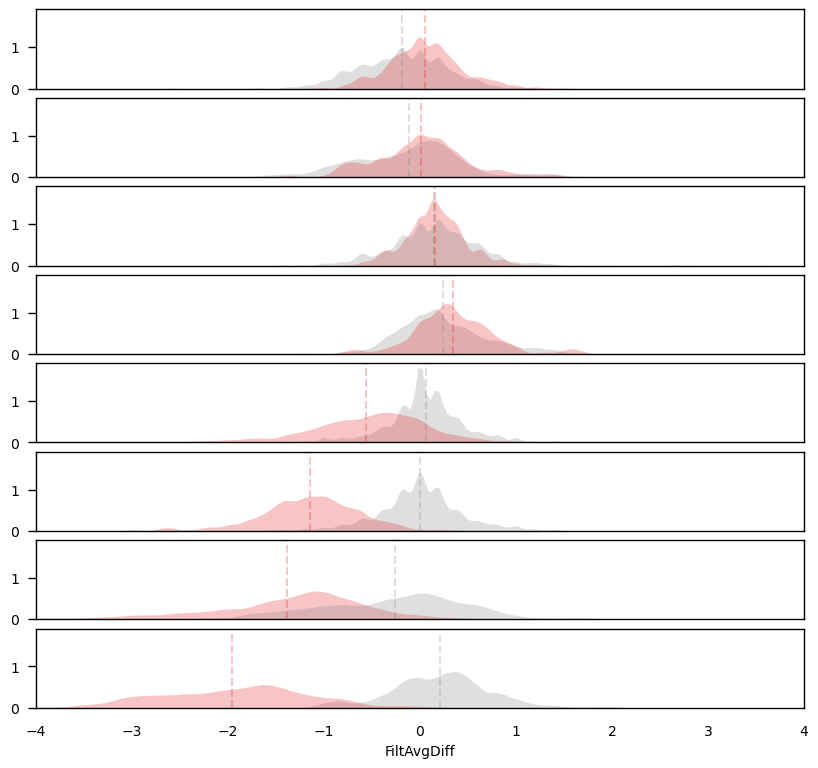

In [45]:
# All patients 
fig, axes = plt.subplots(8, 1, figsize=( 8, 7.5 ), dpi=100, sharex=True, sharey=True)
plot_type_oi = sns.kdeplot
palette_e = { 'True' : sns.color_palette("Paired")[5], 'False' : 'gray' }

min_STRn = 5
bw_adjust_e = 0.5

for idx, patient in enumerate(['CRC2786', 'CRC2821', 'SC040', 'SC041', 'CRC2817', 'CRC2783', 'SC035', 'SC044']):

    adata_obs_oi = adata[(adata.obs['FiltSTRn']>=min_STRn) & 
                        (adata.obs['patient.ID']==patient)].obs
    # tumor_normal_diff = np.mean( adata_obs_oi[(adata_obs_oi['isTumor']=="False")]['UnprocAvgDiff'] ) - np.mean( adata_obs_oi[(adata_obs_oi['isTumor']=="True")]['UnprocAvgDiff'] )
    # print(len(adata_obs_oi))
    print(f'{patient}\t{round(np.mean( adata_obs_oi[(adata_obs_oi['isTumor']=="True")]['FiltAvgDiff'] ), 2)}')
    # print(round(tumor_normal_diff, 2))
    # print(np.std( adata_obs_oi[(adata_obs_oi['isTumor']=="True")]['AvgDiff'] ))
    # print(np.mean( adata_obs_oi[(adata_obs_oi['isTumor']=="True")]['AvgDiff'] ))

    plot_type_oi(data=adata_obs_oi, 
                        x='FiltAvgDiff', hue='isTumor', 
                        legend=None, 
                        fill=True, linewidth=0, common_norm=False, bw_adjust=bw_adjust_e,
                        palette=palette_e, ax=axes[idx], 
                        )
    for isTumor, edf in adata_obs_oi.groupby("isTumor"):
        axes[idx].axvline( np.mean(edf['FiltAvgDiff']), color=palette_e[isTumor], ls='--', alpha=0.25, )
    axes[idx].set_ylabel('');
    # axes[0].set_yticklabels([]);
    axes[idx].tick_params(left=True, bottom=False);

axes[idx].set_xlim([-4, 4]);
# axes[idx].set_ylim([0, 2.2]);

fig.tight_layout(pad=0.05,);

KeyError: 'UnprocSTRn'

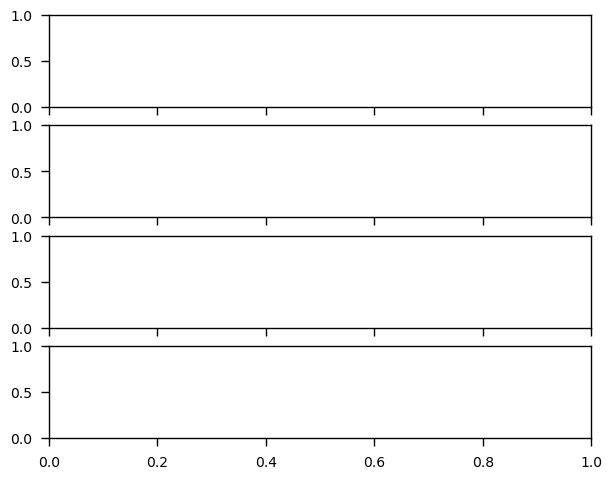

In [38]:
# MSI patients only
fig, axes = plt.subplots(4, 1, figsize=( 7, 5.5 ), dpi=100, sharex=True, sharey=True)
plot_type_oi = sns.kdeplot
palette_e = { 'True' : sns.color_palette("Paired")[5], 'False' : 'gray' }

min_STRn = 10
bw_adjust_e = 0.5

adata_obs_oi = adata[(adata.obs['UnprocSTRn']>=min_STRn) & 
                       (adata.obs['patient.ID']=='CRC2817')].obs
tumor_normal_diff = np.mean( adata_obs_oi[(adata_obs_oi['isTumor']=="False")]['UnprocAvgDiff'] ) - np.mean( adata_obs_oi[(adata_obs_oi['isTumor']=="True")]['UnprocAvgDiff'] )
print(len(adata_obs_oi))
print(round(np.mean( adata_obs_oi[(adata_obs_oi['isTumor']=="True")]['UnprocAvgDiff'] ), 2))
print(round(tumor_normal_diff, 2))
# print(np.std( adata_obs_oi[(adata_obs_oi['isTumor']=="True")]['AvgDiff'] ))
# print(np.mean( adata_obs_oi[(adata_obs_oi['isTumor']=="True")]['AvgDiff'] ))

plot_type_oi(data=adata_obs_oi, 
                       x='UnprocAvgDiff', hue='isTumor', 
                       legend=None, 
                       fill=True, linewidth=0, common_norm=False, bw_adjust=bw_adjust_e,
                       palette=palette_e, ax=axes[0], 
                       )
for isTumor, edf in adata_obs_oi.groupby("isTumor"):
    axes[0].axvline( np.mean(edf['UnprocAvgDiff']), color=palette_e[isTumor], ls='--', alpha=0.25, )
axes[0].set_ylabel('');
# axes[0].set_yticklabels([]);
axes[0].tick_params(left=True, bottom=False);

adata_obs_oi = adata[(adata.obs['UnprocSTRn']>=min_STRn) & 
                       (adata.obs['patient.ID']=='CRC2783')].obs
tumor_normal_diff = np.mean( adata_obs_oi[(adata_obs_oi['isTumor']=="False")]['UnprocAvgDiff'] ) - np.mean( adata_obs_oi[(adata_obs_oi['isTumor']=="True")]['UnprocAvgDiff'] )
print(len(adata_obs_oi))
print(round(np.mean( adata_obs_oi[(adata_obs_oi['isTumor']=="True")]['UnprocAvgDiff'] ), 2))
print(round(tumor_normal_diff, 2))
# print(np.std( adata_obs_oi[(adata_obs_oi['isTumor']=="True")]['AvgDiff'] ))
# print(np.mean( adata_obs_oi[(adata_obs_oi['isTumor']=="True")]['AvgDiff'] ))

plot_type_oi(data=adata_obs_oi, 
                       x='UnprocAvgDiff', hue='isTumor', 
                       legend=None, 
                       fill=True, linewidth=0, common_norm=False, bw_adjust=bw_adjust_e,
                       palette=palette_e, ax=axes[1]
                       )
for isTumor, edf in adata_obs_oi.groupby("isTumor"):
    axes[1].axvline( np.mean(edf['UnprocAvgDiff']), color=palette_e[isTumor], ls='--', alpha=0.25, )
axes[1].set_ylabel('');
# axes[1].set_yticklabels([]);
axes[1].tick_params(left=True, bottom=False);

adata_obs_oi = adata[(adata.obs['UnprocSTRn']>=min_STRn) & 
                       (adata.obs['patient.ID']=='SC035')].obs
tumor_normal_diff = np.mean( adata_obs_oi[(adata_obs_oi['isTumor']=="False")]['UnprocAvgDiff'] ) - np.mean( adata_obs_oi[(adata_obs_oi['isTumor']=="True")]['UnprocAvgDiff'] )
print(len(adata_obs_oi))
print(round(np.mean( adata_obs_oi[(adata_obs_oi['isTumor']=="True")]['UnprocAvgDiff'] ), 2))
print(round(tumor_normal_diff, 2))
# print(np.std( adata_obs_oi[(adata_obs_oi['isTumor']=="True")]['AvgDiff'] ))
# print(np.mean( adata_obs_oi[(adata_obs_oi['isTumor']=="True")]['AvgDiff'] ))

plot_type_oi(data=adata_obs_oi, 
                       x='UnprocAvgDiff', hue='isTumor', 
                       legend=None, 
                       fill=True, linewidth=0, common_norm=False, bw_adjust=bw_adjust_e,
                       palette=palette_e, ax=axes[2]
                       )
for isTumor, edf in adata_obs_oi.groupby("isTumor"):
    axes[2].axvline( np.mean(edf['UnprocAvgDiff']), color=palette_e[isTumor], ls='--', alpha=0.25, )
axes[2].set_ylabel('');
# axes[2].set_yticklabels([]);
axes[2].tick_params(left=True, bottom=False);

adata_obs_oi = adata[(adata.obs['UnprocSTRn']>=min_STRn) & 
                       (adata.obs['patient.ID']=='SC044')].obs
tumor_normal_diff = np.mean( adata_obs_oi[(adata_obs_oi['isTumor']=="False")]['UnprocAvgDiff'] ) - np.mean( adata_obs_oi[(adata_obs_oi['isTumor']=="True")]['UnprocAvgDiff'] )
print(len(adata_obs_oi))
print(round(np.mean( adata_obs_oi[(adata_obs_oi['isTumor']=="True")]['UnprocAvgDiff'] ), 2))
print(round(tumor_normal_diff, 2))
# print(np.std( adata_obs_oi[(adata_obs_oi['isTumor']=="True")]['AvgDiff'] ))
# print(np.mean( adata_obs_oi[(adata_obs_oi['isTumor']=="True")]['AvgDiff'] ))

plot_type_oi(data=adata_obs_oi, 
                       x='UnprocAvgDiff', hue='isTumor', 
                       legend=None, 
                       fill=True, linewidth=0, common_norm=False, bw_adjust=bw_adjust_e,
                       palette=palette_e, ax=axes[3]
                       )
for isTumor, edf in adata_obs_oi.groupby("isTumor"):
    axes[3].axvline( np.mean(edf['UnprocAvgDiff']), color=palette_e[isTumor], ls='--', alpha=0.25, )
axes[3].set_xlabel('');
axes[3].set_ylabel('');
# axes[3].set_yticklabels([]);
axes[3].tick_params(left=True, bottom=True);

axes[3].set_xlim([-4, 4]);
axes[3].set_ylim([0, 2.2]);

fig.tight_layout();

In [39]:
adata.write('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/SG1_KUL_combined/AuthorAdata/iCMS3.basicPreprocessing.annotated.NanoMnT_labeled.h5ad')

### SComatic --> Does not yield good results

#### Run SComatic via subprocess

In [50]:
import subprocess

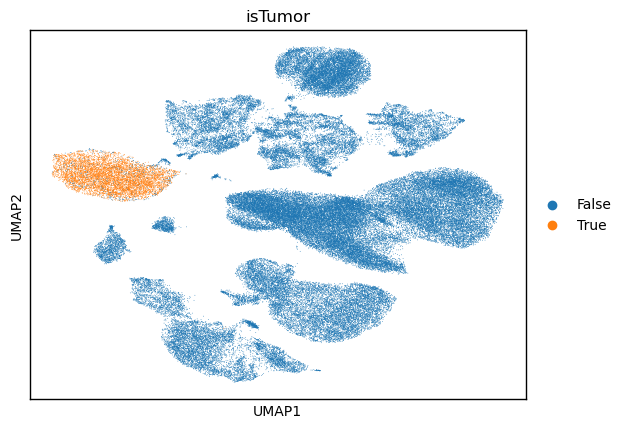

In [40]:
sc.pl.umap(adata, color=['isTumor'])

In [81]:
DIR_SComatic_save = '/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/SG1_KUL_combined/AuthorAdata/SComatic'

adata.obs['CB'] = [ f"{uid.split('_')[0]}-1" for uid in adata.obs['unique_ID'] ]
for patient, edf in adata.obs.groupby("patient.ID"):
    meta_edf = edf[['CB', 'isTumor']].reset_index(drop=True)
    meta_edf.columns = ['Index', 'Cell_type']
    meta_edf['Cell_type'].replace({'True' : 'Tumor', 'False' : 'Normal'}, inplace=True)
    meta_edf.to_csv(f"{DIR_SComatic_save}/meta_{patient}.tsv", sep='\t', index=False)

In [40]:
DIR_SG1_cellranger = "/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/CRC-SG1/cellranger"
DIR_KUL_cellranger = "/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/KUL/MSI_H/cellranger"

In [83]:
# Step 1: Splitting alignment file into cell-type-specific bams

PATH_script = '/home/18parkky/git/SComatic/scripts/SplitBam/SplitBamCellTypes.py'

for patient, edf in df_metadata[(df_metadata['patient.ID'].isin(['CRC2817', "CRC2783", 'SC035', 'SC044']))].groupby("patient.ID"): # 'CRC2786', 'CRC2821', 
    print(patient)
    
    for tup in edf.itertuples():
    
        if "CRC" in patient:
            DIR_cellranger  = f"{DIR_SG1_cellranger}/{tup.file_ID}/outs"
        else:
            DIR_cellranger  = f"{DIR_KUL_cellranger}/{tup.file_ID}/outs"

        PATH_BAM        = f"{DIR_cellranger}/possorted_genome_bam.bam"

        if os.path.isfile( PATH_BAM ) == True:
            DIR_out = f"{DIR_SComatic_save}/{tup.file_ID}"
            if os.path.exists( DIR_out ) == False: os.mkdir(DIR_out)
            
            PATH_meta = f"{DIR_SComatic_save}/meta_{patient}.tsv"
            cmd = f'python {PATH_script} --bam {PATH_BAM} --meta {PATH_meta} --id {tup.file_ID} --outdir {DIR_out}'
            subprocess.call( cmd, shell=True )
        
        else:
            print( tup.file_ID )
            raise ValueError

CRC2783
Number of reads already processed: 5000000
Number of reads already processed: 10000000
Number of reads already processed: 15000000
Number of reads already processed: 20000000
Number of reads already processed: 25000000
Number of reads already processed: 30000000
Number of reads already processed: 35000000
Number of reads already processed: 40000000
Number of reads already processed: 45000000
Number of reads already processed: 50000000
Number of reads already processed: 55000000
Number of reads already processed: 60000000
Number of reads already processed: 65000000
Number of reads already processed: 70000000
Number of reads already processed: 75000000
Number of reads already processed: 80000000
Number of reads already processed: 85000000
Number of reads already processed: 90000000
Number of reads already processed: 95000000
Number of reads already processed: 100000000
Number of reads already processed: 105000000
Number of reads already processed: 110000000
Number of reads alread

In [92]:
# Step 2: Collecting base count information (~600 minutes for 4 patients)
PATH_script = '/home/18parkky/git/SComatic/scripts/BaseCellCounter/BaseCellCounter.py'

nprocs = 24
PATH_reference_genome = '/home/shared/cellranger_reference/refdata-gex-GRCh38-2020-A/fasta/genome.fa'

for patient, edf in df_metadata[(df_metadata['patient.ID'].isin(['CRC2817', "CRC2783", 'SC035', 'SC044']))].groupby("patient.ID"): # 'CRC2786', 'CRC2821', 
    print(patient)

    for tup in edf.itertuples():
        
        PATH_sample_out = f'/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/SG1_KUL_combined/AuthorAdata/SComatic/{tup.file_ID}'
        PATH_tumor_bam   = f'{PATH_sample_out}/{tup.file_ID}.Tumor.bam'
        PATH_normal_bam  = f'{PATH_sample_out}/{tup.file_ID}.Normal.bam'
        
        if (os.path.isfile(PATH_tumor_bam) == False) or (os.path.isfile(PATH_normal_bam) == False):
            print(tup.file_ID)
            raise ValueError
        
        cmd = f'python {PATH_script} --bam {PATH_tumor_bam} --ref {PATH_reference_genome} --chrom all --out_folder {PATH_sample_out} --tmp_dir {PATH_sample_out} --nprocs {nprocs}'
        subprocess.call(cmd, shell=True)
        
        cmd = f'python {PATH_script} --bam {PATH_normal_bam} --ref {PATH_reference_genome} --chrom all --out_folder {PATH_sample_out} --tmp_dir {PATH_sample_out} --nprocs {nprocs}'
        subprocess.call(cmd, shell=True)
    
    break 

CRC2783
Outfile:  /node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/SG1_KUL_combined/AuthorAdata/SComatic/XHC078/XHC078.Tumor.tsv 

Directory  /node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/SG1_KUL_combined/AuthorAdata/SComatic/XHC078  already exists

Computation time: 337 seconds
Outfile:  /node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/SG1_KUL_combined/AuthorAdata/SComatic/XHC078/XHC078.Normal.tsv 

Directory  /node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/SG1_KUL_combined/AuthorAdata/SComatic/XHC078  already exists

Computation time: 1895 seconds
Outfile:  /node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/SG1_KUL_combined/AuthorAdata/SComatic/XHC079/XHC079.Tumor.tsv 

Directory  /node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/SG1_KUL_combined/AuthorAdata/SComatic/XHC079  already exists

Computation time: 435 seconds
Outfile:  /node200data/18pa

In [108]:
# Step 3: Merging base count matrices
PATH_script = '/home/18parkky/git/SComatic/scripts/MergeCounts/MergeBaseCellCounts.py'

DIR_step2_out = '/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/SG1_KUL_combined/AuthorAdata/SComatic'
for patient, edf in df_metadata[(df_metadata['patient.ID'].isin(['CRC2817', "CRC2783", 'SC035', 'SC044']))].groupby("patient.ID"): # 'CRC2786', 'CRC2821', 
    print(patient)
    
    for tup in edf.itertuples():
        
        DIR_out = f'{DIR_step2_out}/{tup.file_ID}'
        if os.path.exists(DIR_out) == False:
            print(tup.file_ID)
            raise ValueError
        
        cmd = f'python {PATH_script} --tsv_folder {DIR_out} --outfile {DIR_out}/{tup.file_ID}.merged.tsv'
        subprocess.call(cmd, shell=True)

CRC2783
-----------------------------------------------------------
1. Merging cell types in a unique tsv file
-----------------------------------------------------------

2 tsv files found

Done...

Time: 185.21 seconds
-----------------------------------------------------------
1. Merging cell types in a unique tsv file
-----------------------------------------------------------

2 tsv files found

Done...

Time: 137.43 seconds
-----------------------------------------------------------
1. Merging cell types in a unique tsv file
-----------------------------------------------------------

2 tsv files found

Done...

Time: 274.78 seconds
-----------------------------------------------------------
1. Merging cell types in a unique tsv file
-----------------------------------------------------------

2 tsv files found

Done...

Time: 266.51 seconds
-----------------------------------------------------------
1. Merging cell types in a unique tsv file
-------------------------------------

In [ ]:
# Step 4: Detection of somatic mutations
# Step 4.1
PATH_script = '/home/18parkky/git/SComatic/scripts/BaseCellCalling/BaseCellCalling.step1.py'
PATH_reference_genome = '/home/shared/cellranger_reference/refdata-gex-GRCh38-2020-A/fasta/genome.fa'

DIR_step3_out = '/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/SG1_KUL_combined/AuthorAdata/SComatic'
# /node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/SG1_KUL_combined/AuthorAdata/SComatic/EXT048/EXT048.merged.tsv
for patient, edf in df_metadata[(df_metadata['patient.ID'].isin(['CRC2817', "CRC2783", 'SC035', 'SC044']))].groupby("patient.ID"): # 'CRC2786', 'CRC2821', 
    print(patient)
    for tup in edf.itertuples():
        
        PATH_infile = f'{DIR_step3_out}/{tup.file_ID}/{tup.file_ID}.merged.tsv'
        if os.path.isfile(PATH_infile) == False:
            print(tup.file_ID)
            raise ValueError

        PATH_outfile = f'{DIR_step3_out}/{tup.file_ID}/{tup.file_ID}.somatic_mut_called.tsv'
        cmd = f"python {PATH_script} --infile {PATH_infile} --outfile {PATH_outfile} --ref {PATH_reference_genome} --min_ac_cells 5 --min_ac_reads 10 --min_cell_types 1"
        subprocess.call(cmd, shell=True)

In [120]:
def findSampleOrigin( sample_alias ):
    sa = sample_alias.lower()
    for keyword in [ 'core', 'invasive', 'tumor' ]:
        if keyword in sa: return 'Tumor'
    for keyword in ['lymphnode']:
        if keyword in sa: return 'LymphNode'
    for keyword in ['normal']:
        if keyword in sa: return 'Normal'
    raise ValueError
    
df_metadata['sample_origin'] = [ findSampleOrigin(sa) for sa in df_metadata['sample_alias'] ]

In [124]:
# Step 4.2
PATH_script         = '/home/18parkky/git/SComatic/scripts/BaseCellCalling/BaseCellCalling.step2.py'
PATH_PoN            = '/home/18parkky/git/SComatic/PoNs/PoN.scRNAseq.hg38.tsv.gz' # Panel of Normal
PATH_RNA_editing    = '/home/18parkky/git/SComatic/RNAediting/AllEditingSites.hg38.txt.gz'

DIR_step4_out = '/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/SG1_KUL_combined/AuthorAdata/SComatic'

# /node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/SG1_KUL_combined/AuthorAdata/SComatic/EXT048/EXT048.merged.tsv
for patient, edf in df_metadata[(df_metadata['patient.ID'].isin(['CRC2817', "CRC2783", 'SC035', 'SC044']))].groupby("patient.ID"): # 'CRC2786', 'CRC2821', 
    print(patient)
    for tup in edf.itertuples():
        
        PATH_infile = f'{DIR_step4_out}/{tup.file_ID}/{tup.file_ID}.somatic_mut_called.tsv.calling.step1.tsv'
        if os.path.isfile(PATH_infile) == False:
            print(tup.file_ID)
            raise ValueError

        PATH_outfile = f'{DIR_step4_out}/{tup.file_ID}/{tup.file_ID}.somatic_mut_called'
        cmd = f"python {PATH_script} --infile {PATH_infile} --outfile {PATH_outfile} --editing {PATH_RNA_editing} --pon {PATH_PoN}"
        subprocess.call(cmd, shell=True)

CRC2783

------------------------------
Variant calling
------------------------------


- Variant calling step 2

	> Editing file used:  /home/18parkky/git/SComatic/RNAediting/AllEditingSites.hg38.txt.gz
	> PoN file used:  /home/18parkky/git/SComatic/PoNs/PoN.scRNAseq.hg38.tsv.gz

Total computing time: 20.18 seconds

------------------------------
Variant calling
------------------------------


- Variant calling step 2

	> Editing file used:  /home/18parkky/git/SComatic/RNAediting/AllEditingSites.hg38.txt.gz
	> PoN file used:  /home/18parkky/git/SComatic/PoNs/PoN.scRNAseq.hg38.tsv.gz

Total computing time: 13.94 seconds

------------------------------
Variant calling
------------------------------


- Variant calling step 2

	> Editing file used:  /home/18parkky/git/SComatic/RNAediting/AllEditingSites.hg38.txt.gz
	> PoN file used:  /home/18parkky/git/SComatic/PoNs/PoN.scRNAseq.hg38.tsv.gz

Total computing time: 34.93 seconds

------------------------------
Variant calling
-----------

In [154]:
# SingleCellGenotyping
PATH_script = '/home/18parkky/git/SComatic/scripts/SingleCellGenotype/SingleCellGenotype.py'
PATH_reference_genome = '/home/shared/cellranger_reference/refdata-gex-GRCh38-2020-A/fasta/genome.fa'
nprocs = 12

set_PASS = set( ['PASS'] )

for patient, edf in df_metadata[(df_metadata['patient.ID'].isin(['CRC2817', "CRC2783", 'SC035', 'SC044']))].groupby("patient.ID"): # 'CRC2786', 'CRC2821', 
    print(patient)
    
    PATH_meta = f'/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/SG1_KUL_combined/AuthorAdata/SComatic/meta_{patient}.tsv'
    if os.path.isfile(PATH_meta) == False:
        raise ValueError
    
    for tup in edf.itertuples():
        
        PATH_infile_raw = f'{DIR_step4_out}/{tup.file_ID}/{tup.file_ID}.somatic_mut_called.calling.step2.tsv'
        PATH_infile_filt = f'{DIR_step4_out}/{tup.file_ID}/{tup.file_ID}.somatic_mut_called.calling.step2.filt.tsv'

        df_infile_raw = pd.read_csv(PATH_infile_raw, sep='\t', skiprows=28)
        
        # Get PASSED variants only
        col_bool_pass_filter = list()
        for ctf in df_infile_raw['Cell_type_Filter']:
            set_filter_res = set(ctf.split(","))
            if set_filter_res == set_PASS:
                col_bool_pass_filter.append( True )
            else:
                col_bool_pass_filter.append( False )

        df_infile_raw['bool_pass_filter'] = col_bool_pass_filter
        df_infile_raw[(df_infile_raw['bool_pass_filter']==True)].to_csv(PATH_infile_filt, 
                                                                        sep='\t', index=False)
        
        PATH_normal_bam = f'{DIR_step4_out}/{tup.file_ID}/{tup.file_ID}.Normal.bam'
        PATH_tumor_bam  = f'{DIR_step4_out}/{tup.file_ID}/{tup.file_ID}.Tumor.bam'

        cmd = f'python {PATH_script} --bam {PATH_normal_bam} --infile {PATH_infile_filt} --ref {PATH_reference_genome} --meta {PATH_meta} --outfile {DIR_step4_out}/{tup.file_ID}/scGenotypeRes.normal.tsv --nprocs {nprocs} --tmp_dir {DIR_step4_out}/{tup.file_ID}/tmpdir'
        subprocess.call(cmd, shell=True)
        
        cmd = f'python {PATH_script} --bam {PATH_tumor_bam} --infile {PATH_infile_filt} --ref {PATH_reference_genome} --meta {PATH_meta} --outfile {DIR_step4_out}/{tup.file_ID}/scGenotypeRes.tumor.tsv --nprocs {nprocs} --tmp_dir {DIR_step4_out}/{tup.file_ID}/tmpdir'
        subprocess.call(cmd, shell=True)

CRC2783
Outfile:  /node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/SG1_KUL_combined/AuthorAdata/SComatic/XHC078/scGenotypeRes.normal.tsv 

Directory  /node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/SG1_KUL_combined/AuthorAdata/SComatic/XHC078/tmpdir  created

Computation time: 329 seconds
Outfile:  /node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/SG1_KUL_combined/AuthorAdata/SComatic/XHC078/scGenotypeRes.tumor.tsv 

Directory  /node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/SG1_KUL_combined/AuthorAdata/SComatic/XHC078/tmpdir  already exists

Computation time: 84 seconds
Outfile:  /node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/SG1_KUL_combined/AuthorAdata/SComatic/XHC079/scGenotypeRes.normal.tsv 

Directory  /node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/SG1_KUL_combined/AuthorAdata/SComatic/XHC079/tmpdir  created

Computation time: 289 seconds


In [159]:
# Merge scGenotyping Results 
list_scGenotype_res = list()

for patient, edf in df_metadata[(df_metadata['patient.ID'].isin(['CRC2817', "CRC2783", 'SC035', 'SC044']))].groupby("patient.ID"): # 'CRC2786', 'CRC2821', 
    print(patient)
    
    PATH_meta = f'/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/SG1_KUL_combined/AuthorAdata/SComatic/meta_{patient}.tsv'
    if os.path.isfile(PATH_meta) == False:
        raise ValueError
    
    for tup in edf.itertuples():
        PATH_scGenotype_normal_res  = f'{DIR_step4_out}/{tup.file_ID}/scGenotypeRes.normal.tsv'
        PATH_scGenotype_tumor_res   = f'{DIR_step4_out}/{tup.file_ID}/scGenotypeRes.tumor.tsv'

        scGenotype_normal_res   = pd.read_csv(PATH_scGenotype_normal_res, sep='\t')
        scGenotype_tumor_res    = pd.read_csv(PATH_scGenotype_tumor_res, sep='\t')
        
        scGenotype_normal_res['cell_type']  = 'normal'
        scGenotype_tumor_res['cell_type']   = 'tumor'
        
        scGenotype_res_e = pd.concat( [scGenotype_tumor_res, scGenotype_normal_res] )
        scGenotype_res_e['patient'] = patient
        scGenotype_res_e['file_ID'] = tup.file_ID

        list_scGenotype_res.append( scGenotype_res_e )
        
scGenotype_res = pd.concat( list_scGenotype_res )
# scGenotype_res.to_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/SG1_KUL_combined/AuthorAdata/SComatic/scGenotypeRes.concat_raw.tsv', sep='\t', index=False)

CRC2783


/tmp/ipykernel_195158/160604973.py:16: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
/tmp/ipykernel_195158/160604973.py:16: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
/tmp/ipykernel_195158/160604973.py:16: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
/tmp/ipykernel_195158/160604973.py:16: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.


CRC2817


/tmp/ipykernel_195158/160604973.py:16: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
/tmp/ipykernel_195158/160604973.py:16: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
/tmp/ipykernel_195158/160604973.py:16: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
/tmp/ipykernel_195158/160604973.py:16: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.


SC035


/tmp/ipykernel_195158/160604973.py:16: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
/tmp/ipykernel_195158/160604973.py:16: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
/tmp/ipykernel_195158/160604973.py:16: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.


SC044


/tmp/ipykernel_195158/160604973.py:16: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
/tmp/ipykernel_195158/160604973.py:16: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
/tmp/ipykernel_195158/160604973.py:16: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.


In [330]:
# Get PASS variants (output of step 4.2)
list_passed_variants = list()
for patient, edf in df_metadata[(df_metadata['patient.ID'].isin(['CRC2817', "CRC2783", 'SC035', 'SC044']))].groupby("patient.ID"): # 'CRC2786', 'CRC2821', 
    print(patient)
    
    for tup in edf.itertuples():
        PATH_step4_2_filt = f'{DIR_step4_out}/{tup.file_ID}/{tup.file_ID}.somatic_mut_called.calling.step2.filt.tsv'
        step4_2_filt = pd.read_csv(PATH_step4_2_filt, sep='\t')
        step4_2_filt['patient'] = patient
        
        list_passed_variants.append( step4_2_filt )

passed_variants = pd.concat(  list_passed_variants)
passed_variants['site'] = [ f'{list(tup)[1]}-{tup.Start}-{tup.End}' for tup in passed_variants.itertuples() ]

CRC2783
CRC2817
SC035
SC044


In [332]:
# scGenotype_res.to_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/SG1_KUL_combined/AuthorAdata/SComatic/scGenotypeRes.concat_filt.tsv', sep='\t', index=False)

scGenotype_res = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/SG1_KUL_combined/AuthorAdata/SComatic/scGenotypeRes.concat_filt.tsv', sep='\t')
scGenotype_res['site'] = [ f'{list(tup)[1]}-{tup.Start}-{tup.End}' for tup in scGenotype_res.itertuples() ]
# scGenotype_res = scGenotype_res[(scGenotype_res['Num_reads']>=10)]

/tmp/ipykernel_195158/2622232353.py:3: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.


In [342]:
scGenotype_res_mut = scGenotype_res[(scGenotype_res['ALT_expected']==scGenotype_res['Base_observed']) & 
                                    (scGenotype_res['Cell_type_expected']==scGenotype_res['Cell_type_observed'])
                                    ].copy()
scGenotype_res_mut['unique_ID'] = [ f"{tup.CB}-{tup.file_ID}" for tup in scGenotype_res_mut.itertuples() ]

In [323]:
scGenotype_res[(scGenotype_res['ALT_expected']==scGenotype_res['Base_observed']) & 
               (scGenotype_res['Cell_type_expected']==scGenotype_res['Cell_type_observed'])]

#CHROM     Start       End REF ALT_expected Cell_type_expected  \
14       GL000220.1    100296    100296   G            A              Tumor   
15       GL000220.1    100310    100310   C            T              Tumor   
17       KI270713.1     20483     20483   C            T              Tumor   
33             chr1   1162557   1162557   A            G              Tumor   
372            chr1   6197732   6197732   T            G              Tumor   
...             ...       ...       ...  ..          ...                ...   
3433655        chrY  11474015  11474015   A            G             Normal   
3433669        chrY  11474020  11474020   G            A             Normal   
3433682        chrY  11474031  11474031   C            T             Normal   
3433691        chrY  11474039  11474039   T            C             Normal   
3433698        chrY  11474057  11474057   C            T             Normal   

        Num_cells_expected                CB Cell_type_observed Base_observed  \
14                       5  CTGGTCTTCCATGCTC              Tumor             A   
15                       6  GACTACAAGGAATCGC              Tumor             T   
17                       9  CTACACCCAGGGTTAG              Tumor             T   
33                       8  CTGATAGAGACAGACC              Tumor             G   
372                     70  AGCTCCTCATGTTCCC              Tumor             G   
...                    ...               ...                ...           ...   
3433655                 24  ACGGAGATCATCGCTC             Normal             G   
3433669                 32  AACCATGAGATGGGTC             Normal             A   
3433682                 24  AACCATGAGATGGGTC             Normal             T   
3433691                 23  AACCATGAGATGGGTC             Normal             C   
3433698                 52  ACTGAACAGGGATGGG             Normal             T   

         Num_reads cell_type  patient file_ID  
14               9     tumor  CRC2783  XHC078  
15               5     tumor  CRC2783  XHC078  
17               5     tumor  CRC2783  XHC078  
33               5     tumor  CRC2783  XHC078  
372              5     tumor  CRC2783  XHC078  
...            ...       ...      ...     ...  
3433655        158    normal    SC044  EXT129  
3433669        132    normal    SC044  EXT129  
3433682        126    normal    SC044  EXT129  
3433691        135    normal    SC044  EXT129  
3433698        481    normal    SC044  EXT129  

[629136 rows x 14 columns]

<Axes: xlabel='Cell_type_observed', ylabel='count'>

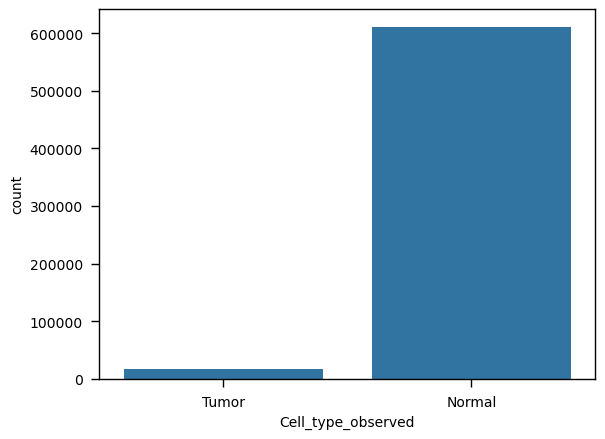

In [325]:
sns.countplot(data=scGenotype_res[(scGenotype_res['ALT_expected']==scGenotype_res['Base_observed']) & 
               (scGenotype_res['Cell_type_expected']==scGenotype_res['Cell_type_observed'])], x='Cell_type_observed')

In [312]:
list_CB_avg_variants = list()
for unique_ID, edf in scGenotype_res_mut.groupby("unique_ID"):
    patient = edf.iloc[0].patient 
    cell_type = edf.iloc[0].cell_type
    
    list_CB_avg_variants.append( [ patient, cell_type, unique_ID, len(edf) ] )
CB_avg_variants = pd.DataFrame(list_CB_avg_variants, columns=['patient', 'cell_type', 'unique_ID', 'num_variants'])

<Axes: xlabel='patient', ylabel='num_variants'>

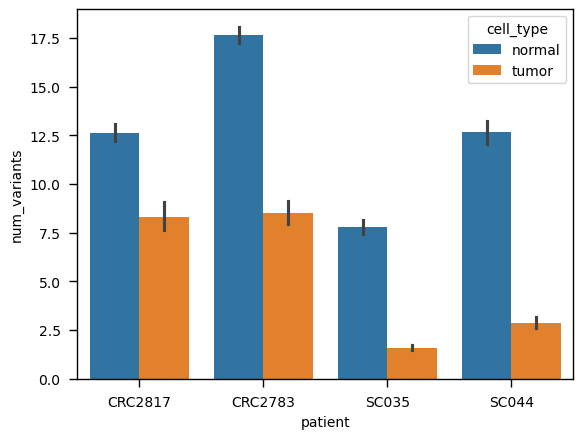

In [314]:
sns.barplot(data=CB_avg_variants, x='patient', order=['CRC2817', 'CRC2783', 'SC035', 'SC044'], y='num_variants', hue='cell_type')

In [255]:
for patient, edf in scGenotype_res_mut.groupby('patient'):
    print(patient)
    PATH_cell_meta = f'/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/SG1_KUL_combined/AuthorAdata/SComatic/meta_{patient}.tsv'
    cell_meta = pd.read_csv( PATH_cell_meta, sep='\t' )
    cell_meta['CB'] = [ i.split("-")[0] for i in cell_meta['Index'] ]
    
    num_total_tumor_cells   = len(cell_meta[(cell_meta['Cell_type']=='Tumor')])
    num_mutated_tumor_cells = len(set(scGenotype_res_mut[(scGenotype_res_mut['patient']==patient)]['CB']))
    print(f"{num_total_tumor_cells}\t{num_mutated_tumor_cells}\t{num_mutated_tumor_cells/num_total_tumor_cells}")


CRC2783
15583	13826	0.8872489251106975
CRC2817
23652	18357	0.776128868594622
SC035
9480	6066	0.639873417721519
SC044
7270	5706	0.784869325997249


In [245]:
cell_meta

Index Cell_type                CB
0     AAACGGGCAATGGACG-1     Tumor  AAACGGGCAATGGACG
1     AAACGGGCAATGTTGC-1     Tumor  AAACGGGCAATGTTGC
2     AAAGATGCAAACCTAC-1     Tumor  AAAGATGCAAACCTAC
3     AAATGCCAGCGTTGCC-1     Tumor  AAATGCCAGCGTTGCC
4     AAATGCCGTTGTTTGG-1     Tumor  AAATGCCGTTGTTTGG
...                  ...       ...               ...
7644  TTTGTCAGTTGGACCC-1    Normal  TTTGTCAGTTGGACCC
7645  TTTGTCATCAGCATGT-1    Normal  TTTGTCATCAGCATGT
7646  TTTGTCATCCATGAGT-1    Normal  TTTGTCATCCATGAGT
7647  TTTGTCATCGGTTCGG-1    Normal  TTTGTCATCGGTTCGG
7648  TTTGTCATCTATCGCC-1    Normal  TTTGTCATCTATCGCC

[7649 rows x 3 columns]

### Tumor-intrinsic factors that may drive difference in MSI

In [470]:
adata_tumor = adata[adata.obs['cell_type_lvl1']=='Tumor'].copy()
adata_tumor = adata_tumor.raw.to_adata()

#### DEG across patients

In [471]:
sc.tl.rank_genes_groups( adata_tumor, groupby='patient.ID', method='wilcoxon' )

In [497]:
pd.DataFrame(adata_tumor.uns['rank_genes_groups']['names'])[['CRC2786', 'CRC2821', 'SC040', 'SC041', 'CRC2817', 'CRC2783', 'SC035', 'SC044']].T

0         1         2      3         4       5         6      \
CRC2786     PIGR    RNASE1      KLF6  FAM3D       LYZ   NEAT1      LCN2   
CRC2821    EIF3G      UBL5    PET100  TSTD1      LY6E   CDC37       B2M   
SC040       RAC1     HLA-B      BST2  HLA-A     HLA-C    NENF   C4orf48   
SC041      PRAC1      RAC1      RBP4   GNB2  TMEM176A   MZT2A     ITM2C   
CRC2817     TFF1        F3  C19orf33  C4BPB    S100A6   TXNIP    ATP1B1   
CRC2783     NME2      NRN1       GSN   DSC3     ITM2C   EEF1G      TPM2   
SC035    PRELID1   ATP5F1D   CHCHD10  CALB1     CENPV   KRT10      MLEC   
SC044     PRSS21  MARCKSL1     NSUN2    ID3   TSPAN13  KDELR2  SERPINH1   

         7         8        9      ...     33277     33278    33279    33280  \
CRC2786   SOX9     NR4A1     FOSB  ...     ARPC5   S100A16     PFN1    KRT10   
CRC2821  AP1M2  TMEM176B     SLPI  ...       BSG    NDUFC1  ATP5F1D    NPDC1   
SC040    FAM3B   PLA2G2A    PCBP1  ...      CD55    EIF4A2    MGST3  ATP5MC2   
SC041    GTF3A     PHGR1    SSU72  ...      BEX3   TXNDC17    RRBP1    UQCC2   
CRC2817  FXYD3      KLK1  S100A11  ...  TMEM176A   DNAJC15  SLC25A6      FBL   
CRC2783  RGS10    PDLIM1     BEX3  ...   SLC40A1      CYC1    CALM2     SLPI   
SC035    CISD3       AK5   NDUFA6  ...     IFI27     WFDC2   IFITM2      FOS   
SC044    PRAC1       RDX    NUPR1  ...   CEACAM5  C19orf33     NQO1     TFF3   

           33281    33282   33283   33284     33285    33286  
CRC2786    MGST3   ATP5ME  COX6A1   ITM2B      SRP9  C4orf48  
CRC2821  TMEM141  CHCHD10    XBP1    SDF4    ATP1B1   MALAT1  
SC040    S100A13   NUCKS1  DAZAP2   SUMO2     PPDPF   CDKN2A  
SC041      YWHAE      MIF  MRPL52    PFN1       UBB   OCIAD2  
CRC2817     FTH1    TOMM7  EEF1B2    LDHB     EEF1D    RACK1  
CRC2783     PPA1   TSPAN8   CLDN3   PRSS3  HIST1H4C      LYZ  
SC035        JUN    FCGBP    CD74   HLA-B     HLA-C    HLA-A  
SC044      H2AFJ   LGALS3     LYZ  S100A6     IFI27   LGALS4  

[8 rows x 33287 columns]

In [474]:
dict_deg = {
 'CRC2817': ['S100A6', 'TFF1', 'C19orf33', 'F3'],
 'SC035': ['PRELID1', 'ATP5F1D', 'CHCHD10', 'CALB1'],
  'CRC2783': ['NME2', 'GSN', 'PIGR', 'ITM2C'],
 'SC044': ['PRSS21', 'NUPR1', 'HLA-A', 'CCND2'], 
 }

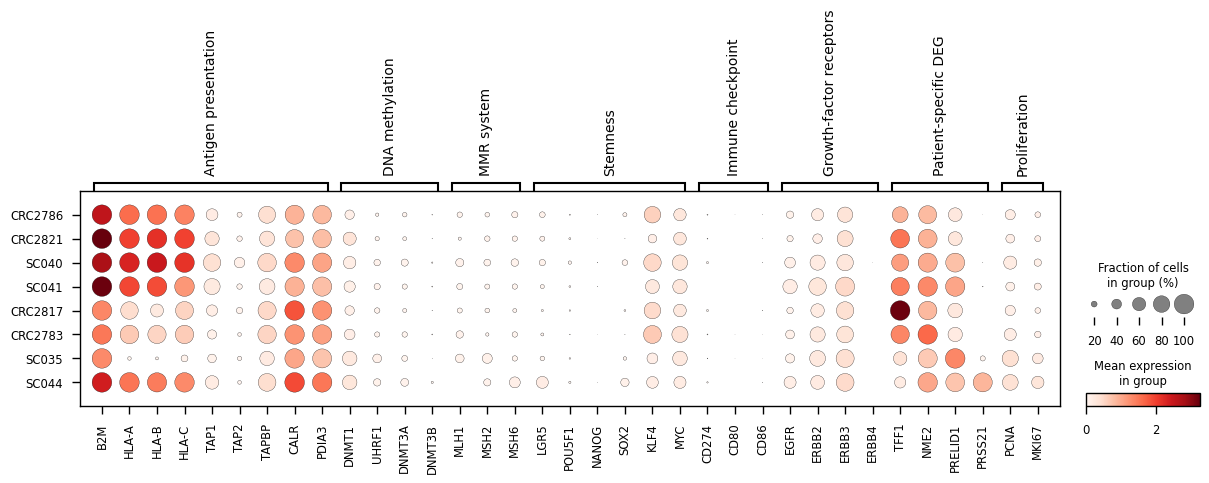

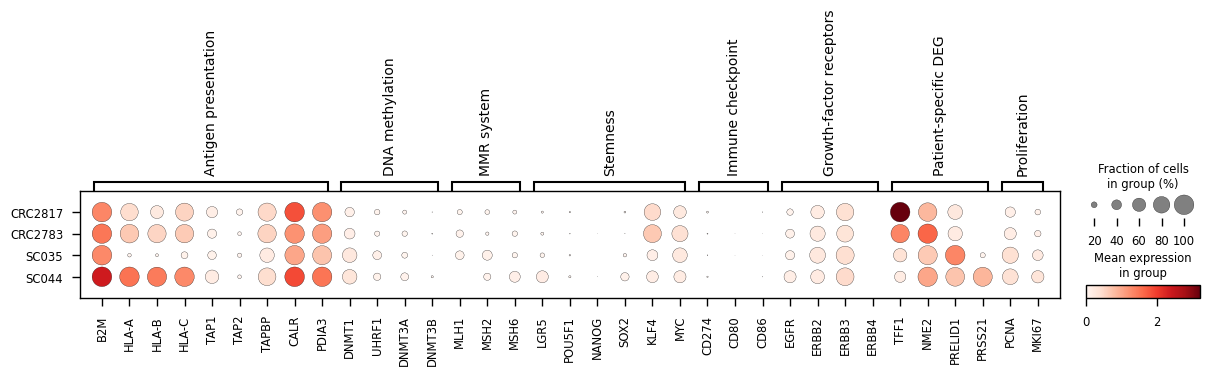

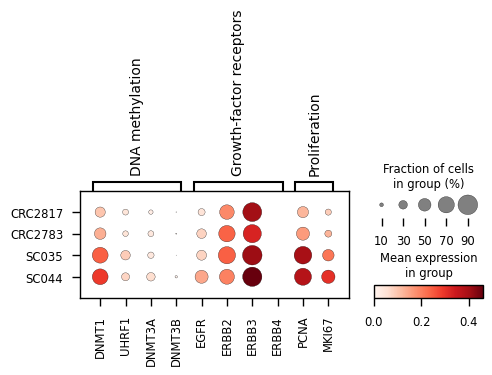

In [595]:
sc.pl.dotplot( adata_tumor, {'Antigen presentation' : ['B2M', 'HLA-A', 'HLA-B', 'HLA-C', 'TAP1', 'TAP2', 'TAPBP', 'CALR', 'PDIA3'], 
                             'DNA methylation' : ['DNMT1', 'UHRF1', 'DNMT3A', 'DNMT3B',], 
                             'MMR system' : ['MLH1', 'MSH2', 'MSH6'],
                             'Stemness' : ['LGR5', 'POU5F1', 'NANOG', 'SOX2', 'KLF4', 'MYC'],
                             'Immune checkpoint' : ['CD274', 'CD80', 'CD86'],
                            #  'Colon-epithelial' : ['MUC2', 'CDX2', 'AQP8', 'OCLN'],
                            #  'Stomach-epithelial' : ['GAST', 'MUC5AC', 'PGA3', 'PGA4'],
                             'Growth-factor receptors' : ['EGFR', 'ERBB2', 'ERBB3', 'ERBB4'],
                             'Patient-specific DEG' : ['TFF1', 'NME2', 'PRELID1', 'PRSS21'],
                             'Proliferation' : ['PCNA', 'MKI67'],}, 
              groupby="patient.ID", swap_axes=False, categories_order=['CRC2786', 'CRC2821', 'SC040', 'SC041', 'CRC2817', 'CRC2783', 'SC035', 'SC044'],
              # groupby="MSI_status", swap_axes=False,
              )

sc.pl.dotplot( adata_tumor[adata_tumor.obs['MSI_status']=='MSI'], 
              {'Antigen presentation' : ['B2M', 'HLA-A', 'HLA-B', 'HLA-C', 'TAP1', 'TAP2', 'TAPBP', 'CALR', 'PDIA3'], 
                             'DNA methylation' : ['DNMT1', 'UHRF1', 'DNMT3A', 'DNMT3B',], 
                             'MMR system' : ['MLH1', 'MSH2', 'MSH6'],
                             'Stemness' : ['LGR5', 'POU5F1', 'NANOG', 'SOX2', 'KLF4', 'MYC'],
                             'Immune checkpoint' : ['CD274', 'CD80', 'CD86'],
                            #  'Colon-epithelial' : ['MUC2', 'CDX2', 'AQP8', 'OCLN'],
                            #  'Stomach-epithelial' : ['GAST', 'MUC5AC', 'PGA3', 'PGA4'],
                             'Growth-factor receptors' : ['EGFR', 'ERBB2', 'ERBB3', 'ERBB4'],
                             'Patient-specific DEG' : ['TFF1', 'NME2', 'PRELID1', 'PRSS21'],
                             'Proliferation' : ['PCNA', 'MKI67'],}, 
              groupby="patient.ID", swap_axes=False, categories_order=['CRC2817', 'CRC2783', 'SC035', 'SC044'],
              # groupby="MSI_status", swap_axes=False,
              )

sc.pl.dotplot( adata_tumor[adata_tumor.obs['MSI_status']=='MSI'], 
              {
                             'DNA methylation' : ['DNMT1', 'UHRF1', 'DNMT3A', 'DNMT3B',], 
                            #  'Colon-epithelial' : ['MUC2', 'CDX2', 'AQP8', 'OCLN'],
                            #  'Stomach-epithelial' : ['GAST', 'MUC5AC', 'PGA3', 'PGA4'],
                             'Growth-factor receptors' : ['EGFR', 'ERBB2', 'ERBB3', 'ERBB4'],
                             'Proliferation' : ['PCNA', 'MKI67'],
                             }, 
              groupby="patient.ID", swap_axes=False, categories_order=['CRC2817', 'CRC2783', 'SC035', 'SC044'],
              # groupby="MSI_status", swap_axes=False,
              )

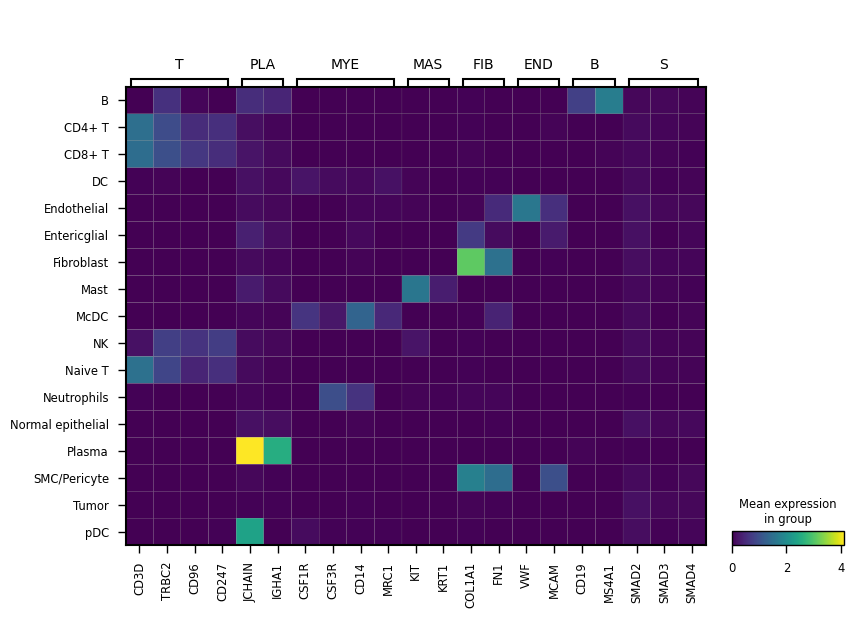

In [113]:
sc.pl.matrixplot(adata, var_names={ 'T' : ['CD3D', 'TRBC2', 'CD96', 'CD247'], 
                                'PLA' : ['JCHAIN', 'IGHA1'], 'MYE' : ['CSF1R', 'CSF3R', 'CD14', 'MRC1'], 
                                'MAS' : ['KIT', 'KRT1'], 
                                'FIB' : ['COL1A1', 'FN1'], 
                                'END' : ['VWF', 'MCAM'], 
                                'B' : ['CD19', 'MS4A1'],
                                'S' : ['SMAD2', 'SMAD3','SMAD4'],
                                }, 
                                
              groupby='cell_type_lvl1')

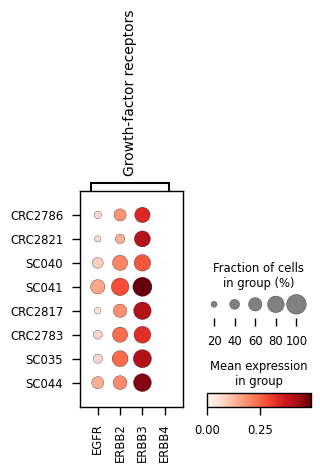

In [591]:
sc.pl.dotplot( adata_tumor, {'Growth-factor receptors' : ['EGFR', 'ERBB2', 'ERBB3', 'ERBB4'] },
              groupby="patient.ID", 
              swap_axes=False, categories_order=['CRC2786', 'CRC2821', 'SC040', 'SC041', 'CRC2817', 'CRC2783', 'SC035', 'SC044'],
              # groupby="MSI_status", swap_axes=False,
              )

In [564]:
set(adata.obs['cell.type'])

{'B',
 'Endothelial',
 'Entericglial',
 'Epithelial',
 'Fibroblast',
 'Mast',
 'McDC',
 'Neutrophils',
 'PlasmaB',
 'T_NK',
 'pDC'}

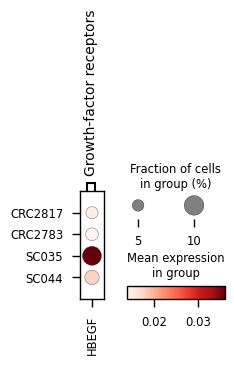

In [581]:
sc.pl.dotplot( adata[(adata.obs['MSI_status']=='MSI') & 
                     (adata.obs['cell_type_lvl1'].isin(['Fibroblast', 'SMC/Pericyte'])) & 
                     (adata.obs['sample.origin2']!='Normal')], {'Growth-factor receptors' : ['HBEGF'] },
              groupby="patient.ID", swap_axes=False, categories_order=['CRC2817', 'CRC2783', 'SC035', 'SC044'],
              # groupby="MSI_status", swap_axes=False,
              )

#### Cell cycle score

In [46]:

iCMS2_up = list(df_iCMS_marker['iCMS2_Up'].dropna())
iCMS2_dw = list(df_iCMS_marker['iCMS2_Down'].dropna())
iCMS3_up = list(df_iCMS_marker['iCMS3_Up'].dropna())
iCMS3_dw = list(df_iCMS_marker['iCMS3_Down'].dropna())

sc.tl.score_genes(adata_tumor, iCMS2_up, score_name='iCMS2_up')
sc.tl.score_genes(adata_tumor, iCMS2_dw, score_name='iCMS2_dw')
sc.tl.score_genes(adata_tumor, iCMS3_up, score_name='iCMS3_up')
sc.tl.score_genes(adata_tumor, iCMS3_dw, score_name='iCMS3_dw')

sc.tl.score_genes(adata_tumor, iCMS2_up + iCMS3_dw, score_name='iCMS2_score')
sc.tl.score_genes(adata_tumor, iCMS3_up + iCMS2_dw, score_name='iCMS3_score')

In [47]:
PATH_cellcycle_marker = '/node200data/18parkky/datasets/reference/marker_genes/cell_cycle/cell_cycle_marker.tsv'

df_cellcycle = pd.read_csv(PATH_cellcycle_marker, sep='\t')

sc.tl.score_genes_cell_cycle( adata_tumor, 
                             s_genes=list(df_cellcycle[df_cellcycle['phase']=='S']['gene_symbol']), 
                             g2m_genes=list(df_cellcycle[df_cellcycle['phase']=='G2/M']['gene_symbol']),  )

In [63]:
sc.tl.score_genes_cell_cycle( adata, 
                             s_genes=list(df_cellcycle[df_cellcycle['phase']=='S']['gene_symbol']), 
                             g2m_genes=list(df_cellcycle[df_cellcycle['phase']=='G2/M']['gene_symbol']),  )

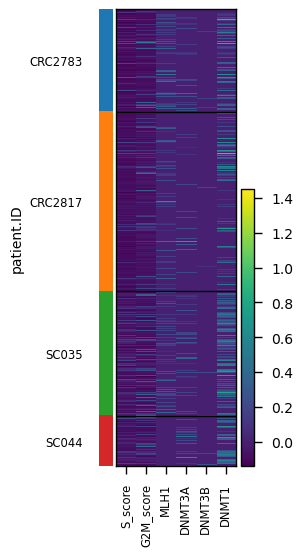

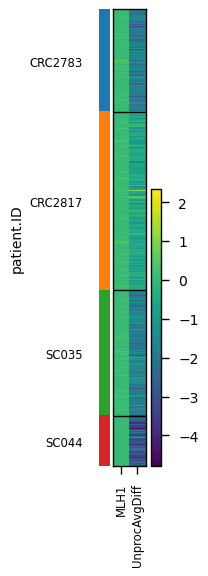

In [95]:
sc.pl.heatmap(adata_tumor, var_names=['S_score', 'G2M_score', 'MLH1', 'DNMT3A', 'DNMT3B', 'DNMT1',], 
              groupby='patient.ID', 
              #categories_order=['CRC2817', 'CRC2783', 'SC035', 'SC044'] 
              )
sc.pl.heatmap(adata_tumor[adata_tumor.obs['UnprocSTRn']>=10], var_names=['MLH1', 'UnprocAvgDiff'], 
              groupby='patient.ID', 
            #   categories_order=['CRC2817', 'CRC2783', 'SC035', 'SC044'] 
              )
# sc.pl.dotplot(adata_tumor[adata_tumor.obs['patient.ID'].isin(['CRC2817', 'CRC2783'])], var_names=['S_score', 'G2M_score', 'MLH1', 'DNMT3A', 'DNMT3B', 'DNMT1'], groupby='patient.ID', categories_order=['CRC2817', 'CRC2783',] )
# sc.pl.dotplot(adata_tumor[adata_tumor.obs['patient.ID'].isin(['SC035', 'SC044'])], var_names=['S_score', 'G2M_score', 'MLH1', 'DNMT3A', 'DNMT3B', 'DNMT1'], groupby='patient.ID', categories_order=['SC035', 'SC044'] )

[Text(0, 0, '47.23'), Text(0, 0, '26.12'), Text(0, 0, '26.65')]

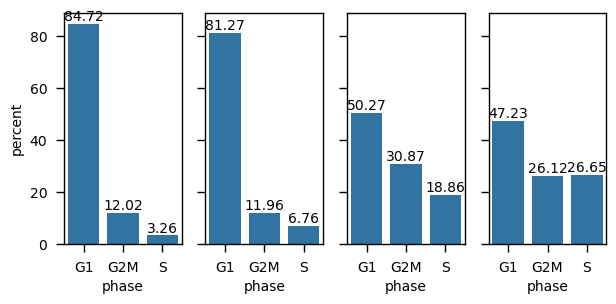

In [76]:
fig, axes = plt.subplots(1, 4, figsize=(7, 3), sharey=True, sharex=True)
f = sns.countplot(data=adata_tumor.obs[(adata_tumor.obs['patient.ID']=='CRC2817')], x='phase', stat='percent', ax=axes[0])
f.bar_label(f.containers[0], fmt='%.2f')
f = sns.countplot(data=adata_tumor.obs[(adata_tumor.obs['patient.ID']=='CRC2783')], x='phase', stat='percent', ax=axes[1])
f.bar_label(f.containers[0], fmt='%.2f')
f = sns.countplot(data=adata_tumor.obs[(adata_tumor.obs['patient.ID']=='SC035')], x='phase', stat='percent', ax=axes[2])
f.bar_label(f.containers[0], fmt='%.2f')
f = sns.countplot(data=adata_tumor.obs[(adata_tumor.obs['patient.ID']=='SC044')], x='phase', stat='percent', ax=axes[3])
f.bar_label(f.containers[0], fmt='%.2f')

In [79]:
adata_epithelial = adata[adata.obs['cell.type']=='Epithelial'].copy()
adata_epithelial = adata_epithelial.raw.to_adata()

In [ ]:
sc.tl.umap(adata_epithelial)

In [ ]:
adata_epithelial.raw = adata_epithelial
sc.pp.highly_variable_genes(adata_epithelial, n_top_genes=4000, flavor='seurat', batch_key='dataset' )
adata_epithelial = adata_epithelial[:, adata_epithelial.var.highly_variable]

sc.tl.pca(adata_epithelial, svd_solver="arpack")
sc.pp.neighbors(adata_epithelial, n_neighbors=25, n_pcs=40, use_rep='X_pca')
sc.tl.umap(adata_epithelial)

### Cell cycle & iCMS marker gene scores

In [258]:
df_iCMS_marker = pd.read_csv('/node200data/18parkky/datasets/reference/marker_genes/colon/iCMS_marker/iCMS_marker_genes.csv')

iCMS2_up = list(df_iCMS_marker['iCMS2_Up'].dropna())
iCMS2_dw = list(df_iCMS_marker['iCMS2_Down'].dropna())
iCMS3_up = list(df_iCMS_marker['iCMS3_Up'].dropna())
iCMS3_dw = list(df_iCMS_marker['iCMS3_Down'].dropna())

sc.tl.score_genes(adata_epithelial, iCMS2_up, score_name='iCMS2_up')
sc.tl.score_genes(adata_epithelial, iCMS2_dw, score_name='iCMS2_dw')
sc.tl.score_genes(adata_epithelial, iCMS3_up, score_name='iCMS3_up')
sc.tl.score_genes(adata_epithelial, iCMS3_dw, score_name='iCMS3_dw')

sc.tl.score_genes(adata_epithelial, iCMS2_up + iCMS3_dw, score_name='iCMS2_score')
sc.tl.score_genes(adata_epithelial, iCMS3_up + iCMS2_dw, score_name='iCMS3_score')

In [408]:
sc.tl.score_genes(adata, iCMS2_up, score_name='iCMS2_up')
sc.tl.score_genes(adata, iCMS2_dw, score_name='iCMS2_dw')
sc.tl.score_genes(adata, iCMS3_up, score_name='iCMS3_up')
sc.tl.score_genes(adata, iCMS3_dw, score_name='iCMS3_dw')

In [418]:
adata

AnnData object with n_obs × n_vars = 59414 × 4000
    obs: 'nCount_RNA.x', 'nFeature_RNA.x', 'percent.mt', 'sample.ID', 'patient.ID', 'sample.origin', 'dataset', 'cell.type', 'orig.ident', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'leiden_res_0.02', 'leiden_res_0.10', 'leiden_res_0.20', 'leiden_res_0.30', 'leiden_res_0.50', 'leiden_res_1.00', 'cell_type_lvl1', 'cell_type_lvl2', 'unique_ID', 'unprocAvgDiff', 'unprocStdDiff', 'unprocSTRn', 'procAvgDiff', 'procStdDiff', 'procSTRn', 'isTumor', 'iCMS2_up', 'iCMS2_dw', 'iCMS3_up', 'iCMS3_dw'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_

In [259]:
PATH_cellcycle_marker = '/node200data/18parkky/datasets/reference/marker_genes/cell_cycle/cell_cycle_marker.tsv'

df_cellcycle = pd.read_csv(PATH_cellcycle_marker, sep='\t')

sc.tl.score_genes_cell_cycle( adata_epithelial, 
                             s_genes=list(df_cellcycle[df_cellcycle['phase']=='S']['gene_symbol']), 
                             g2m_genes=list(df_cellcycle[df_cellcycle['phase']=='G2/M']['gene_symbol']),  )

In [267]:
for res in [0.02, 0.1, 0.5, 1.0]:
    print(res)
    sc.tl.leiden(
        adata_epithelial, key_added=f"leiden_res_{res:4.2f}", resolution=res, 
    )

0.02
0.1
0.5
1.0


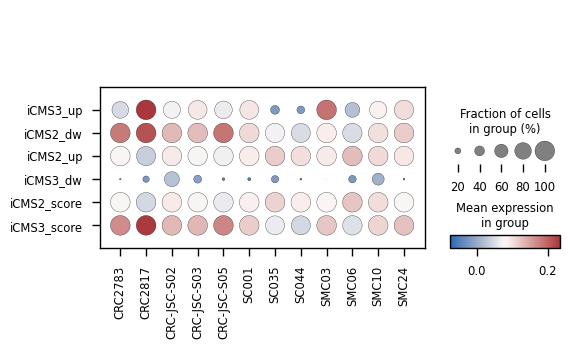

In [299]:
sc.pl.dotplot(adata_epithelial[(adata_epithelial.obs['leiden_res_0.50']!='6')], 
              ['iCMS3_up', 'iCMS2_dw', 'iCMS2_up', 'iCMS3_dw', 'iCMS2_score', 'iCMS3_score'], groupby='patient.ID', cmap='vlag', swap_axes=True,)

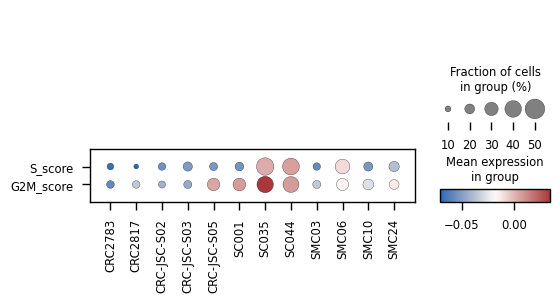

In [301]:
sc.pl.dotplot(adata_epithelial[(adata_epithelial.obs['leiden_res_0.50']!='6')], 
              ['S_score', 'G2M_score'], groupby='patient.ID', cmap='vlag', swap_axes=True,)

#### (1) Cell cycle difference between patients (Tumor)

<Axes: xlabel='phase', ylabel='perc'>

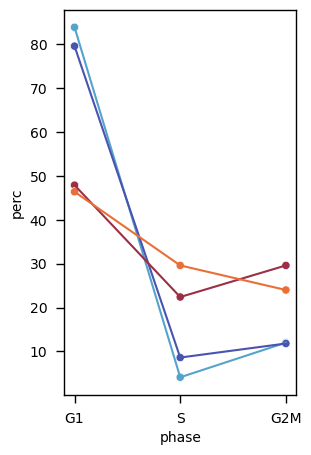

In [347]:
# fig, axes = plt.subplots( 4, 1, figsize=(9, 5), dpi=100, sharex=True, sharey=True )
# dict_patient_to_axes = { 'CRC2817' : 0, 'CRC2783' : 1, 'SC035' : 2, 'SC044' : 3, }
# for patient, edf in adata_epithelial[(adata_epithelial.obs['leiden_res_0.50']!='6') & (adata_epithelial.obs['patient.ID'].isin(['CRC2817', 'CRC2783', 'SC035', 'SC044',]))].obs.groupby('patient.ID'):
#     f = sns.countplot(data=edf, y='phase', stat='percent', ax=axes[dict_patient_to_axes[patient]])
#     f.bar_label(f.containers[0], fmt='%.1f');
    
df_cellcycle_portion = pd.DataFrame([ ['CRC2817', "G1", 83.9, ], 
                                     ['CRC2817', "S", 4.1, ], 
                                     ['CRC2817', "G2M", 12.0, ], 

                                     ['CRC2783', "G1", 79.6, ],
                                     ['CRC2783', "S", 8.6, ],
                                     ['CRC2783', "G2M", 11.8, ],

                                     ['SC035', "G1", 47.9, ],
                                     ['SC035', "S", 22.4, ],
                                     ['SC035', "G2M", 29.6, ],

                                     ['SC044', "G1", 46.4, ],
                                     ['SC044', "S", 29.6, ],
                                     ['SC044', "G2M", 24.0, ],
                                     ],)
df_cellcycle_portion.columns = ['patient', 'phase', 'perc']

palette_e = sns.color_palette("rocket_r", 10)[2], sns.color_palette("rocket_r", 10)[4], sns.color_palette("rocket_r", 10)[7], sns.color_palette("rocket_r", 10)[9]
palette_e = sns.color_palette("icefire")[0], sns.color_palette("icefire")[1], sns.color_palette("icefire")[-2], sns.color_palette("icefire")[-1]

plt.figure(figsize=(3, 5), dpi=100)
sns.scatterplot(data=df_cellcycle_portion, x='phase', y='perc', hue='patient', palette=palette_e, legend=False,)
sns.lineplot(data=df_cellcycle_portion, x='phase', y='perc', hue='patient', palette=palette_e, legend=False,)

#### (2) Cell cycle difference between patients (Normal Epithelial)

<Axes: xlabel='phase', ylabel='perc'>

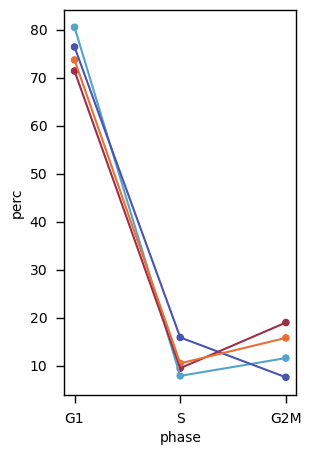

In [348]:
# fig, axes = plt.subplots( 4, 1, figsize=(9, 5), dpi=100, sharex=True, sharey=True )
# dict_patient_to_axes = { 'CRC2817' : 0, 'CRC2783' : 1, 'SC035' : 2, 'SC044' : 3, }
# for patient, edf in adata_epithelial[(adata_epithelial.obs['leiden_res_0.50']=='6') & (adata_epithelial.obs['patient.ID'].isin(['CRC2817', 'CRC2783', 'SC035', 'SC044',]))].obs.groupby('patient.ID'):
#     f = sns.countplot(data=edf, y='phase', stat='percent', ax=axes[dict_patient_to_axes[patient]])
#     f.bar_label(f.containers[0], fmt='%.1f');
    
df_cellcycle_portion = pd.DataFrame([ ['CRC2817', "G1", 80.5, ], 
                                     ['CRC2817', "S", 7.9, ], 
                                     ['CRC2817', "G2M", 11.6, ], 

                                     ['CRC2783', "G1", 76.4, ],
                                     ['CRC2783', "S", 15.9, ],
                                     ['CRC2783', "G2M", 7.6, ],

                                     ['SC035', "G1", 71.4, ],
                                     ['SC035', "S", 9.5, ],
                                     ['SC035', "G2M", 19.0, ],

                                     ['SC044', "G1", 73.7, ],
                                     ['SC044', "S", 10.5, ],
                                     ['SC044', "G2M", 15.8, ],
                                     ],)
df_cellcycle_portion.columns = ['patient', 'phase', 'perc']

palette_e = sns.color_palette("rocket_r", 10)[2], sns.color_palette("rocket_r", 10)[4], sns.color_palette("rocket_r", 10)[7], sns.color_palette("rocket_r", 10)[9]
palette_e = sns.color_palette("icefire")[0], sns.color_palette("icefire")[1], sns.color_palette("icefire")[-2], sns.color_palette("icefire")[-1]

plt.figure(figsize=(3, 5), dpi=100)
sns.scatterplot(data=df_cellcycle_portion, x='phase', y='perc', hue='patient', palette=palette_e, legend=False,)
sns.lineplot(data=df_cellcycle_portion, x='phase', y='perc', hue='patient', palette=palette_e, legend=False,)

#### (3) Cell cycle difference between patients (Tumor vs. Normal Epithelial)

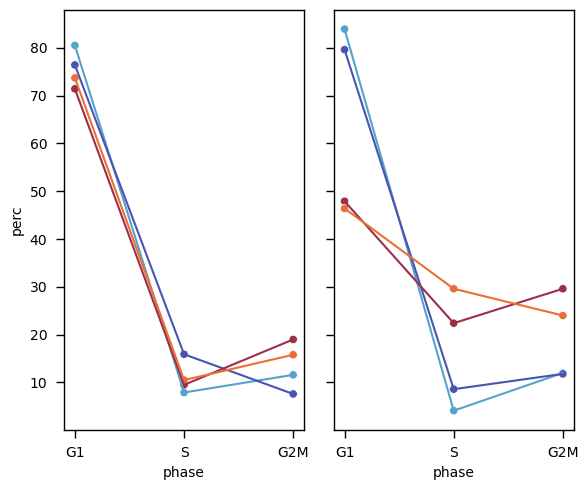

In [351]:
df_cellcycle_portion_tumor = pd.DataFrame([ ['CRC2817', "G1", 83.9, ], 
                                     ['CRC2817', "S", 4.1, ], 
                                     ['CRC2817', "G2M", 12.0, ], 

                                     ['CRC2783', "G1", 79.6, ],
                                     ['CRC2783', "S", 8.6, ],
                                     ['CRC2783', "G2M", 11.8, ],

                                     ['SC035', "G1", 47.9, ],
                                     ['SC035', "S", 22.4, ],
                                     ['SC035', "G2M", 29.6, ],

                                     ['SC044', "G1", 46.4, ],
                                     ['SC044', "S", 29.6, ],
                                     ['SC044', "G2M", 24.0, ],
                                     ],)
df_cellcycle_portion_tumor.columns = ['patient', 'phase', 'perc']

df_cellcycle_portion_normal = pd.DataFrame([ ['CRC2817', "G1", 80.5, ], 
                                     ['CRC2817', "S", 7.9, ], 
                                     ['CRC2817', "G2M", 11.6, ], 

                                     ['CRC2783', "G1", 76.4, ],
                                     ['CRC2783', "S", 15.9, ],
                                     ['CRC2783', "G2M", 7.6, ],

                                     ['SC035', "G1", 71.4, ],
                                     ['SC035', "S", 9.5, ],
                                     ['SC035', "G2M", 19.0, ],

                                     ['SC044', "G1", 73.7, ],
                                     ['SC044', "S", 10.5, ],
                                     ['SC044', "G2M", 15.8, ],
                                     ],)
df_cellcycle_portion_normal.columns = ['patient', 'phase', 'perc']

fig, axes = plt.subplots(1, 2, figsize=(6, 5), sharey=True, sharex=True)
sns.scatterplot(data=df_cellcycle_portion_normal, x='phase', y='perc', hue='patient', palette=palette_e, legend=False, ax=axes[0])
sns.lineplot(data=df_cellcycle_portion_normal, x='phase', y='perc', hue='patient', palette=palette_e, legend=False, ax=axes[0])
sns.scatterplot(data=df_cellcycle_portion_tumor, x='phase', y='perc', hue='patient', palette=palette_e, legend=False, ax=axes[1])
sns.lineplot(data=df_cellcycle_portion_tumor, x='phase', y='perc', hue='patient', palette=palette_e, legend=False, ax=axes[1])
fig.tight_layout();

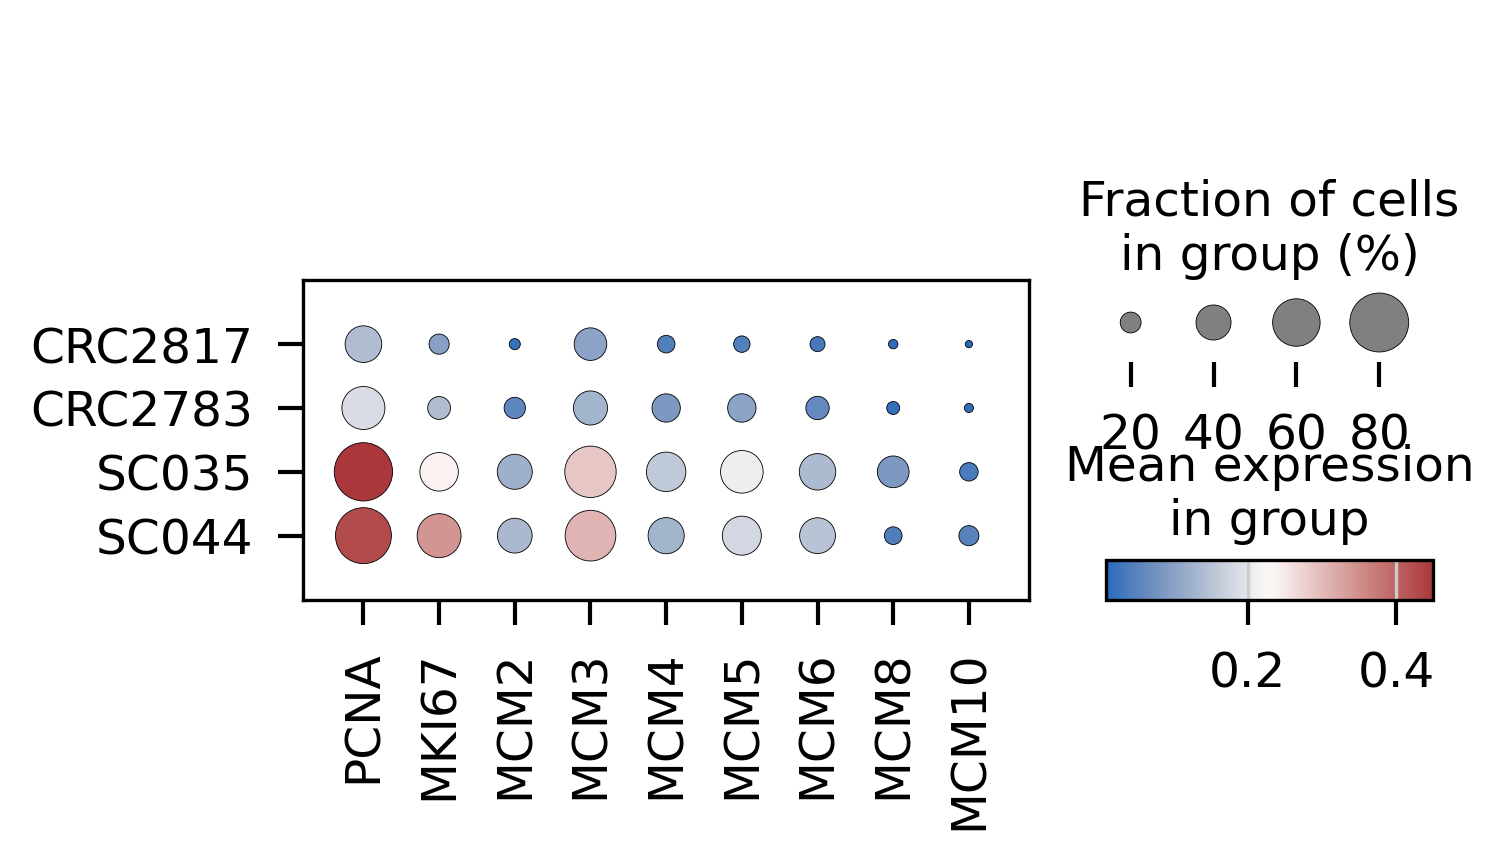

In [356]:
proliferating_markers = ['PCNA', 'MKI67', 'MCM2', 'MCM3', 'MCM4', 'MCM5', 'MCM6', 'MCM8', 'MCM10',] # + ['FEN1', 'RRM1', 'RRM2', 'CDK1', 'RPA2', 'RFC4', 'RFC2', 'PRIM2']
sc.tl.score_genes( adata_epithelial, proliferating_markers, )
sc.set_figure_params(dpi=150)

sc.pl.dotplot(adata_epithelial[(adata_epithelial.obs['leiden_res_0.50']!='6') & (adata_epithelial.obs['patient.ID'].isin(['CRC2817', 'CRC2783', 'SC035', 'SC044']))], 
                proliferating_markers,
              groupby='patient.ID', 
              categories_order=['CRC2817', 'CRC2783', 'SC035', 'SC044'], 
              cmap='vlag',
              swap_axes=False,)

### Get tumor CB

In [365]:
list_normal_epithelial  = list(adata_epithelial[(adata_epithelial.obs['leiden_res_0.10']=='6')].obs['unique_ID'])
list_tumor_epithelial   = list(adata_epithelial[(adata_epithelial.obs['leiden_res_0.10']!='6')].obs['unique_ID'])

In [373]:
adata_total.obs['isTumor'] = [ str(bool(uid in list_tumor_epithelial)) for uid in adata_total.obs['unique_ID']]

### STR allele size distribution

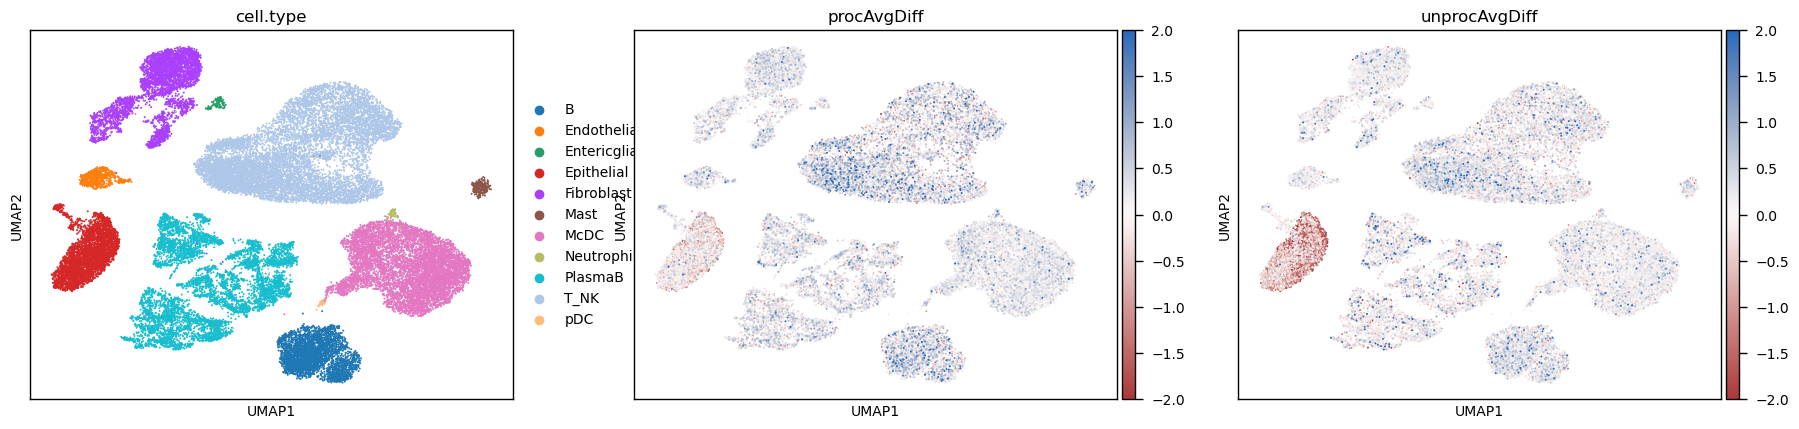

In [83]:
sc.pl.umap(adata[(adata.obs['unprocSTRn']>=10)], color=['cell.type', 'procAvgDiff', 'unprocAvgDiff'], vmin=-2, vmax=2, cmap='vlag_r', s=8)

In [ ]:
fig, axes = plt.subplots(4, 1, figsize=( 7, 5 ), dpi=100, sharex=True, sharey=True)
plot_type_oi = sns.kdeplot
palette_e = { 'True' : sns.color_palette("Paired")[5], 'False' : 'gray' }

min_STRn = 10

adata_obs_oi = adata_total[(adata_total.obs['procSTRn']>=min_STRn) & 
                       (adata_total.obs['patient.ID']=='CRC2817')].obs
print(0.685 * np.std( adata_obs_oi[(adata_obs_oi['isTumor']=="True")]['procAvgDiff'] ))
print(0.685 * np.mean( adata_obs_oi[(adata_obs_oi['isTumor']=="True")]['procAvgDiff'] ))

plot_type_oi(data=adata_obs_oi, 
                       x='procAvgDiff', hue='isTumor', 
                       legend=None, 
                       fill=True, linewidth=0, common_norm=False, bw_adjust=0.5,
                       palette=palette_e, ax=axes[0], 
                       )
for isTumor, edf in adata_obs_oi.groupby("isTumor"):
    axes[0].axvline( np.mean(edf['procAvgDiff']), color=palette_e[isTumor], ls='--', alpha=0.25, )

adata_obs_oi = adata_total[(adata_total.obs['procSTRn']>=min_STRn) & 
                       (adata_total.obs['patient.ID']=='CRC2783')].obs
print(0.685 * np.std( adata_obs_oi[(adata_obs_oi['isTumor']=="True")]['procAvgDiff'] ))
print(0.685 * np.mean( adata_obs_oi[(adata_obs_oi['isTumor']=="True")]['procAvgDiff'] ))

plot_type_oi(data=adata_obs_oi, 
                       x='procAvgDiff', hue='isTumor', 
                       legend=None, 
                       fill=True, linewidth=0, common_norm=False, bw_adjust=0.5,
                       palette=palette_e, ax=axes[1]
                       )
for isTumor, edf in adata_obs_oi.groupby("isTumor"):
    axes[1].axvline( np.mean(edf['procAvgDiff']), color=palette_e[isTumor], ls='--', alpha=0.25, )

adata_obs_oi = adata_total[(adata_total.obs['procSTRn']>=min_STRn) & 
                       (adata_total.obs['patient.ID']=='SC035')].obs
print(0.685 * np.std( adata_obs_oi[(adata_obs_oi['isTumor']=="True")]['procAvgDiff'] ))
print(0.685 * np.mean( adata_obs_oi[(adata_obs_oi['isTumor']=="True")]['procAvgDiff'] ))

plot_type_oi(data=adata_obs_oi, 
                       x='procAvgDiff', hue='isTumor', 
                       legend=None, 
                       fill=True, linewidth=0, common_norm=False, bw_adjust=0.5,
                       palette=palette_e, ax=axes[2]
                       )
for isTumor, edf in adata_obs_oi.groupby("isTumor"):
    axes[2].axvline( np.mean(edf['procAvgDiff']), color=palette_e[isTumor], ls='--', alpha=0.25, )

adata_obs_oi = adata_total[(adata_total.obs['procSTRn']>=min_STRn) & 
                       (adata_total.obs['patient.ID']=='SC044')].obs
print(0.685 * np.std( adata_obs_oi[(adata_obs_oi['isTumor']=="True")]['procAvgDiff'] ))
print(0.685 * np.mean( adata_obs_oi[(adata_obs_oi['isTumor']=="True")]['procAvgDiff'] ))

plot_type_oi(data=adata_obs_oi, 
                       x='procAvgDiff', hue='isTumor', 
                       legend=None, 
                       fill=True, linewidth=0, common_norm=False, bw_adjust=0.5,
                       palette=palette_e, ax=axes[3]
                       )
for isTumor, edf in adata_obs_oi.groupby("isTumor"):
    axes[3].axvline( np.mean(edf['procAvgDiff']), color=palette_e[isTumor], ls='--', alpha=0.25, )
    
axes[3].set_xlim([-5, 5]);

0.22207434147951335
-0.40226532054198877
0.25682419293466957
-1.1766596617796137
0.31151142568774887
-1.2067755805147835
0.3523614412062805
-1.9206605165391206


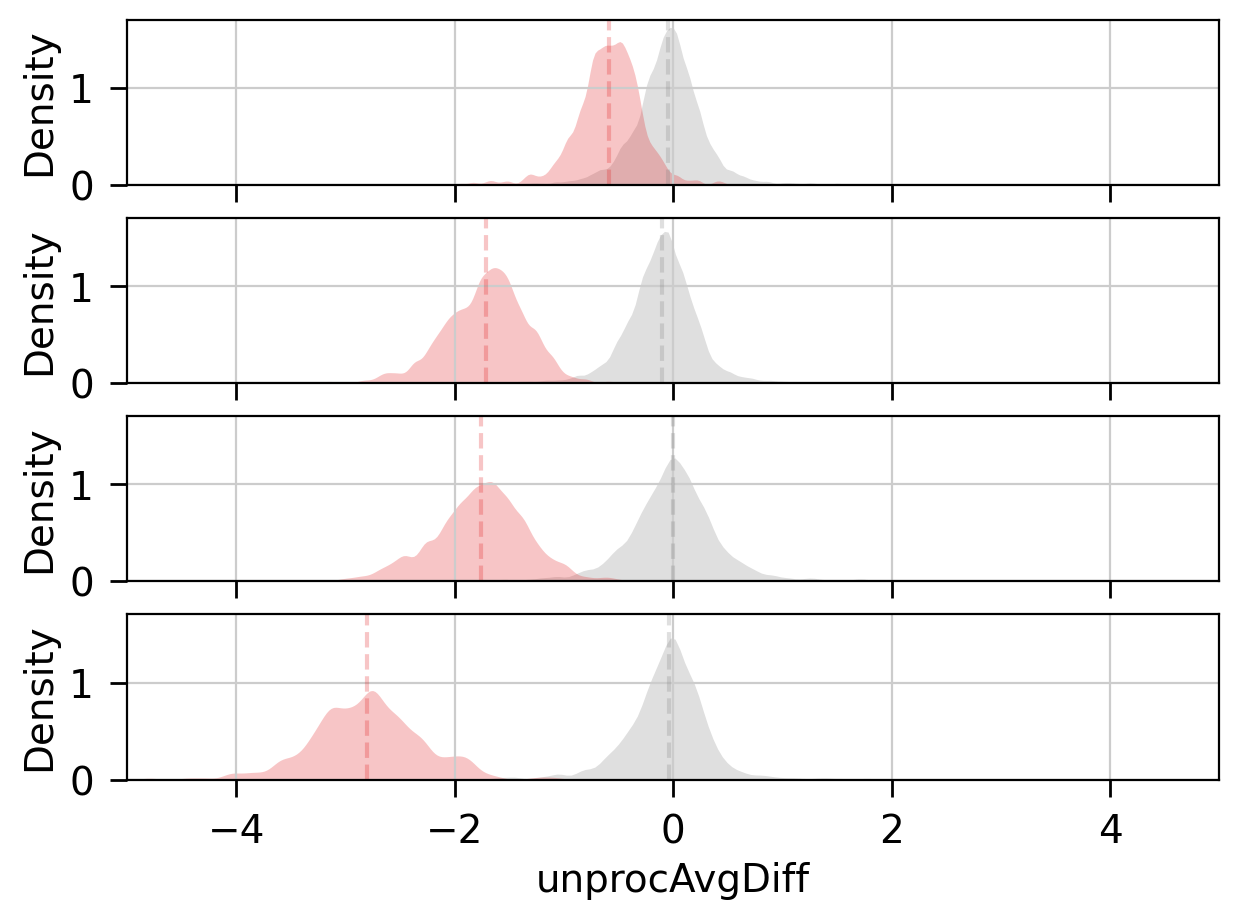

In [485]:
fig, axes = plt.subplots(4, 1, figsize=( 7, 5 ), dpi=100, sharex=True, sharey=True)
plot_type_oi = sns.kdeplot
palette_e = { 'True' : sns.color_palette("Paired")[5], 'False' : 'gray' }

min_n = 20

adata_obs_oi = adata_total[(adata_total.obs['unprocSTRn']>=min_n) & 
                       (adata_total.obs['patient.ID']=='CRC2817')].obs
print(0.685 * np.std( adata_obs_oi[(adata_obs_oi['isTumor']=="True")]['unprocAvgDiff'] ))
print(0.685 * np.mean( adata_obs_oi[(adata_obs_oi['isTumor']=="True")]['unprocAvgDiff'] ))

plot_type_oi(data=adata_obs_oi, 
                       x='unprocAvgDiff', hue='isTumor', 
                       legend=None, 
                       fill=True, linewidth=0, common_norm=False, bw_adjust=0.5,
                       palette=palette_e, ax=axes[0], 
                       )
for isTumor, edf in adata_obs_oi.groupby("isTumor"):
    axes[0].axvline( np.mean(edf['unprocAvgDiff']), color=palette_e[isTumor], ls='--', alpha=0.25, )

adata_obs_oi = adata_total[(adata_total.obs['unprocSTRn']>=min_n) & 
                       (adata_total.obs['patient.ID']=='CRC2783')].obs
print(0.685 * np.std( adata_obs_oi[(adata_obs_oi['isTumor']=="True")]['unprocAvgDiff'] ))
print(0.685 * np.mean( adata_obs_oi[(adata_obs_oi['isTumor']=="True")]['unprocAvgDiff'] ))

plot_type_oi(data=adata_obs_oi, 
                       x='unprocAvgDiff', hue='isTumor', 
                       legend=None, 
                       fill=True, linewidth=0, common_norm=False, bw_adjust=0.5,
                       palette=palette_e, ax=axes[1]
                       )
for isTumor, edf in adata_obs_oi.groupby("isTumor"):
    axes[1].axvline( np.mean(edf['unprocAvgDiff']), color=palette_e[isTumor], ls='--', alpha=0.25, )

adata_obs_oi = adata_total[(adata_total.obs['unprocSTRn']>=min_n) & 
                       (adata_total.obs['patient.ID']=='SC035')].obs
print(0.685 * np.std( adata_obs_oi[(adata_obs_oi['isTumor']=="True")]['unprocAvgDiff'] ))
print(0.685 * np.mean( adata_obs_oi[(adata_obs_oi['isTumor']=="True")]['unprocAvgDiff'] ))

plot_type_oi(data=adata_obs_oi, 
                       x='unprocAvgDiff', hue='isTumor', 
                       legend=None, 
                       fill=True, linewidth=0, common_norm=False, bw_adjust=0.5,
                       palette=palette_e, ax=axes[2]
                       )
for isTumor, edf in adata_obs_oi.groupby("isTumor"):
    axes[2].axvline( np.mean(edf['unprocAvgDiff']), color=palette_e[isTumor], ls='--', alpha=0.25, )

adata_obs_oi = adata_total[(adata_total.obs['unprocSTRn']>=min_n) & 
                       (adata_total.obs['patient.ID']=='SC044')].obs
print(0.685 * np.std( adata_obs_oi[(adata_obs_oi['isTumor']=="True")]['unprocAvgDiff'] ))
print(0.685 * np.mean( adata_obs_oi[(adata_obs_oi['isTumor']=="True")]['unprocAvgDiff'] ))

plot_type_oi(data=adata_obs_oi, 
                       x='unprocAvgDiff', hue='isTumor', 
                       legend=None, 
                       fill=True, linewidth=0, common_norm=False, bw_adjust=0.5,
                       palette=palette_e, ax=axes[3]
                       )
for isTumor, edf in adata_obs_oi.groupby("isTumor"):
    axes[3].axvline( np.mean(edf['unprocAvgDiff']), color=palette_e[isTumor], ls='--', alpha=0.25, )
    
axes[3].set_xlim([-5, 5]);

{'CRC2783', 'CRC2817', 'SC035', 'SC044'}

In [ ]:
sc.pl.umap(adata_epithelial, color=['leiden_res_0.02', 'avg_diff'], vmin=-2, vmax=2, cmap='vlag_r')